# Project 3 - Applied Statistics & Modeling
## Introduction to Dataset
- Electricity Consumption: Normalised values of consumption of electricity across 100 intervals
- Stock Prices: Normalised values of prices of stocks over a 100 day period
- Temperature Fluctuations: Normalised values of temperature fluctuations over 100 intervals
- Advertising Impact: The impact of advertising on some type of performance mectric over 100 intervals
- Sales Data: Normalised values of sales from months over 10 years (120 intervals)
- Exchange Rates: Normalised Values of both exchange rate and economic indicator over 120 intervals

### Loading in Packages

In [126]:
#Base packages that are going to be 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression

In [127]:
#Set the maximum number of rows that can be observed
pd.set_option('display.max_rows', 50)

### Function Creation
When doing a project that may involve reusing lines of data it is best to create a function that can be reused. This improves readability and decreases the reptitive nature of the different data sets. It can also be useful to store these and use them at a later date

In [128]:
#Create a function that is going to plot data 
#It is called time series because that is the type of data it is going to be primarily be dealing with
def time_series(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [129]:
#Create a function that is going to plot multiple series on the same graph
def multiple_time_series(series_list, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    for i, (xdata, ydata) in enumerate(series_list, start=1):
        plt.plot(xdata, ydata, label=f'Series {i}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [130]:
#Create a function that is going to make a bar chart
def bar_chart(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.bar(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [131]:
#Create the Dickey Fuller test to use on data
#Regression type is c, ct, ctt, n
#constant, constant and trend, constant and linear and quadratic trend, no constant and no trend

from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [132]:
#Create a seasonal decomposition of the different parts that make up the data
#Creating a subplot where the values are stacked up on one another makes it easier to read

def plot_seasonal_decomposition(data, period):
    """
    Function to plot the seasonal decomposition of a time series.

    Parameters:
    - data: Pandas Series or DataFrame with a datetime index.
    - freq: Frequency of the seasonal component (e.g., 'D' for daily, 'M' for monthly).

    Returns:
    - None (plots the decomposition).
    """
    decomposition = seasonal_decompose(data, period=period)

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [133]:
#Get the decomposed values which make up the time series
def decompose_seasonality(data, period):    

    decomposition = seasonal_decompose(data, period=period)

    original = data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return original, trend, seasonal, residual

In [134]:
#Create a for loop that replaces the missing values within the mean value
def missing_values_replace(days_replace,data,first_row,last_row):
    for day in days_replace:
        replace_value = data[first_row:last_row][day].mean()
        data.loc[last_row,day] = replace_value
    return data

In [135]:
#Create a for loop that replace the missing values with the most recent value

In [136]:
#Create a rolling mean of the data to understand the trend
#This also incudes the standard deviation to understand the variance in data values

def roll_mean_std_dev(df_column,window):

    plt.figure(figsize=(10,6))
    #Look at the mean and the standard deviation of this data
    rolmean = df_column.rolling(window).mean()
    rolstd = df_column.rolling(window).std()

    #Let's check the stationarity of the graph
    #Plot the rolling statistics
    orig = plt.plot(df_column,color='blue',label='Original')
    mean = plt.plot(rolmean,color='red',label='Rolling Mean')
    std = plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [137]:
#When given a list of daily values it may be useful to break it up into weeks as rows and days as columns
#This is going to help be able to break up the data and perform statistical analysis
def create_weekly_data(df,value_column,incrementing_column):
    
    #Create the list of days as the column names
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    #Make a copy
    original_copy = df.copy()
    original_copy['Incrementing Day'] = range(0, len(original_copy))
    original_copy.set_index(incrementing_column,inplace=True)

    #Determine the number of weeks by adding 6 to the length so that partial weeks are counted
    num_weeks = (len(df)+6) // 7

    #Create a new datadrame where the index is the number of weeks and the columns are the days of the week
    weekly_data = pd.DataFrame(index=range(num_weeks),columns=days_of_week)

    #Fill the empty dataframe with data
    for i, row in original_copy.iterrows():
        week = i // 7
        day = days_of_week[i % 7]
        weekly_data.at[week, day] = row[value_column]

    return weekly_data

In [138]:
#When given a list of daily values which do not include weekend values such as stock data 
#it can be useful to break it up into weeks as rows and days as columns
#This can break up the data to perform statistical analysis

def create_week_day_data(df,value_column,incrementing_column):
    
    #Create the list of days as the column names
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    #Make a copy
    original_copy = df.copy()
    original_copy['Incrementing Day'] = range(0, len(original_copy))
    original_copy.set_index(incrementing_column,inplace=True)

    #Determine the number of weeks by adding 6 to the length so that partial weeks are counted
    num_weeks = (len(df)+4) // 5

    #Create a new datadrame where the index is the number of weeks and the columns are the days of the week
    weekly_data = pd.DataFrame(index=range(num_weeks),columns=days_of_week)

    #Fill the empty dataframe with data
    for i, row in original_copy.iterrows():
        week = i // 5
        day = days_of_week[i % 5]
        weekly_data.at[week, day] = row[value_column]

    return weekly_data

In [139]:
#When dealing with monthly values it can be useful to split it up into months of the year with days within them
def create_monthly_data(df,value_column,incrementing_month):

    #Create list of months
    months = ['January','February','March','April','May','June','July','August','September','October','November','December']

    original_copy = df.copy()
    original_copy['Incrementing Month'] = range(0,len(original_copy))
    original_copy.set_index(incrementing_month,inplace=True)

    #Determine the number of years
    num_years = (len(df)+11) // 12

    #Create a new dataframe where the index is the number of years and the columns are the number of months
    monthly_data = pd.DataFrame(index=range(num_years),columns = months)

    #Fill the empty dataframe
    for i, row in original_copy.iterrows():
        year = i // 12
        month = months[(i) % 12]
        monthly_data.at[year,month] = row[value_column]

    return monthly_data

In [140]:
#Plot the seasonal values that make up the decomposition
def seasonal_values_plot(decomposed_data_seasonal,lag_length,y_column,title,xlabel,period_list,ylabel):
    seasonal_data = pd.DataFrame(decomposed_data_seasonal[0:lag_length])
    plt.figure(figsize=(12,6))
    plt.plot(seasonal_data.index,seasonal_data[y_column])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(seasonal_data.index,period_list)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)

In [141]:
#Find statistical information and add it onto the dataframe
#This is used for weekly data (Monday-Sunday)
def mean_median_variance_std_weekly(data, columns):

    num_weeks = len(data)

    data['Weekly Mean'] = data.sum(axis=1)/7
    data['Weekly Median'] = data[columns].median(axis=1)
    data['Standard Deviation'] = data[columns].std(axis=1)
    data['Variance'] = data[columns].var(axis=1)

    data.loc['Mean'] = data.mean()
    data.loc['Median'] = data.median()
    data.loc['Variance'] = data.var()
    data.loc['Standard Deviation'] = data.std()

    rows_to_select = slice(num_weeks,len(data))
    columns_to_select = slice(7,11)
    data.iloc[rows_to_select,columns_to_select] = pd.np.nan

    return data

In [142]:
#Find statistical information and add it onto the dataframe
#This is used for week-day data (Monday-Friday)
def mean_median_variance_std_week_day(data, columns):

    num_weeks = len(data)

    data['Weekly Mean'] = data.sum(axis=1)/5
    data['Weekly Median'] = data[columns].median(axis=1)
    data['Standard Deviation'] = data[columns].std(axis=1)
    data['Variance'] = data[columns].var(axis=1)

    data.loc['Mean'] = data.mean()
    data.loc['Median'] = data.median()
    data.loc['Variance'] = data.var()
    data.loc['Standard Deviation'] = data.std()

    rows_to_select = slice(num_weeks,len(data))
    columns_to_select = slice(5,9)
    data.iloc[rows_to_select,columns_to_select] = pd.np.nan

    return data

In [143]:
#Find statistical information and add it onto the dataframe
#This is used for weekly data (Monday-Sunday)
def mean_median_variance_std_monthly(data, columns):

    num_months = len(data)

    data['Monthly Mean'] = data.sum(axis=1)/7
    data['Monthly Median'] = data[columns].median(axis=1)
    data['Standard Deviation'] = data[columns].std(axis=1)
    data['Variance'] = data[columns].var(axis=1)

    data.loc['Mean'] = data.mean()
    data.loc['Median'] = data.median()
    data.loc['Variance'] = data.var()
    data.loc['Standard Deviation'] = data.std()

    rows_to_select = slice(num_months,len(data))
    columns_to_select = slice(12,16)
    data.iloc[rows_to_select,columns_to_select] = pd.np.nan

    return data

In [144]:
#Create a least squares line going through the data values

def plot_least_squares_line(x_value, y_value, title, x_label, y_label):
    plt.figure(figsize=(10,6))
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Predicting y values using the model
    y_pred = model.predict(x)

    # Plotting the original data and the least squares line
    plt.scatter(x, y, label='original data', color='blue')
    plt.plot(x, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [145]:
import matplotlib.pyplot as plt

def create_boxplot_multiple_weeks(data, week_indices):
    fig, ax = plt.subplots(figsize=(10, 6))
    boxplot_data = [data.loc[idx] for idx in week_indices]
    ax.boxplot(boxplot_data, labels=week_indices)
    ax.set_title('Box Plot of Weekly Data')
    ax.set_xlabel('Week Index')
    ax.set_ylabel('Values')
    plt.show()


In [146]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def select_best_ar_model(data, ar_orders):

    """
    Selects the best AR model based on AIC and BIC criteria.

    Parameters:
    - data: The time series data.
    - ar_orders: A list of integers for AR(p) orders to test.

    Returns:
    - A dictionary with the best model's details according to AIC and BIC.
    """
    import warnings

    # Suppress the specific warning about inferred frequency
    warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
    
    best_aic, best_bic = np.inf, np.inf
    best_aic_model, best_bic_model = None, None

    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0))  # AR(p) model
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_aic_model = p

            if results.bic < best_bic:
                best_bic = results.bic
                best_bic_model = p

        except Exception as e:
            print(f"Error fitting AR({p}) model: {e}")
            continue

    return {
        'best_aic': best_aic,
        'best_aic_model': best_aic_model,
        'best_bic': best_bic,
        'best_bic_model': best_bic_model
    }


In [147]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def select_best_ma_model(data, ma_orders):
    """
    Selects the best MA model based on AIC and BIC criteria.

    Parameters:
    - data: The time series data.
    - ma_orders: A list of integers for MA(q) orders to test.

    Returns:
    - A dictionary with the best model's details according to AIC and BIC.
    """
    import warnings

    # Suppress the specific warning about inferred frequency
    warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
    
    best_aic, best_bic = np.inf, np.inf
    best_aic_model, best_bic_model = None, None

    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q))  # MA(q) model
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_aic_model = q

            if results.bic < best_bic:
                best_bic = results.bic
                best_bic_model = q

        except Exception as e:
            print(f"Error fitting MA({q}) model: {e}")
            continue

    return {
        'best_aic': best_aic,
        'best_aic_model': best_aic_model,
        'best_bic': best_bic,
        'best_bic_model': best_bic_model
    }


In [148]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

def select_best_arma_model(data, ar_orders, ma_orders):
    """
    Selects the best ARMA model based on AIC and BIC criteria.

    Parameters:
    - data: The time series data.
    - ar_orders: A list of integers for AR(p) orders to test.
    - ma_orders: A list of integers for MA(q) orders to test.

    Returns:
    - A dictionary with the best model's details according to AIC and BIC.
    """
    import warnings

    # Suppress the specific warning about inferred frequency
    warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
    
    best_aic, best_bic = np.inf, np.inf
    best_aic_model, best_bic_model = None, None

    # Generate all combinations of AR and MA orders
    orders = list(product(ar_orders, ma_orders))

    for order in orders:
        try:
            model = ARIMA(data, order=(*order, 0))  # ARMA(p,q) model
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_aic_model = order

            if results.bic < best_bic:
                best_bic = results.bic
                best_bic_model = order

        except Exception as e:
            print(f"Error fitting ARMA{order}: {e}")
            continue

    return {
        'best_aic': best_aic,
        'best_aic_model': best_aic_model,
        'best_bic': best_bic,
        'best_bic_model': best_bic_model
    }


In [149]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

def select_best_arima(data, ar_orders, ma_orders, d_orders):
    """
    Selects the best ARIMA model based on AIC and BIC criteria.

    Parameters:
    - data: The time series data.
    - ar_orders: A list of integers for AR(p) orders to test.
    - ma_orders: A list of integers for MA(q) orders to test.
    - d_orders: A list of integers for differencing (d) orders to test.

    Returns:
    - A dictionary with the best model's details according to AIC and BIC.
    """
    import warnings
    warnings.filterwarnings("ignore")
    
    import warnings

    # Suppress the specific warning about inferred frequency
    warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
    
    best_aic, best_bic = np.inf, np.inf
    best_aic_model, best_bic_model = None, None

    # Generate all combinations of AR, MA, and differencing orders
    orders = list(product(ar_orders, d_orders, ma_orders))

    for order in orders:
        try:
            model = ARIMA(data, order=order)
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_aic_model = order

            if results.bic < best_bic:
                best_bic = results.bic
                best_bic_model = order

        except Exception as e:
            print(f"Error fitting ARIMA{order}: {e}")
            continue

    return {
        'best_aic': best_aic,
        'best_aic_model': best_aic_model,
        'best_bic': best_bic,
        'best_bic_model': best_bic_model
    }


In [251]:
from pmdarima import auto_arima

def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
    """
    Fits a SARIMA model to the provided data, searching over given parameter lists.
    It returns the best model based on AIC and also provides its BIC for comparison.
   
    Parameters:
    - data: Pandas Series of the time series data.
    - p_list, d_list, q_list: Lists of integers for the AR (p), differencing (d), and MA (q) parameters.
    - P_list, D_list, Q_list: Lists of integers for the seasonal AR (P), seasonal differencing (D),
                              and seasonal MA (Q) parameters.
    - s: Integer representing the length of the seasonal cycle.
   
    Returns:
    - A dictionary with the best model's AIC and BIC, along with the corresponding parameters.
    """
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

## Electricity Consumption
The consumption of electricity can be taken as daily or monthly recordings usually. As there is no distinct time interval that is given, some investigaiton is going to be done to decipher the best time interval to choose.

### Data exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [151]:
#Import the different datasets from the excel sheet
electricity_consumption = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Electricity Consumption')

In [152]:
#Preprocess electricity consumption data
#Create a new column called day that is going to be set as the index
#This is done so that the time series can have dates as the x columns
electricity_consumption['Day'] = pd.date_range('2024-01-01',periods=len(electricity_consumption))
electricity_consumption.drop(columns='Unnamed: 0',inplace=True)
electricity_consumption.set_index('Day',inplace=True)
electricity_consumption['Incrementing Day'] = range(1,len(electricity_consumption)+1)
electricity_consumption

,Electricity Consumption,Incrementing Day
Day,,
2024-01-01,1.764052,1
2024-01-02,1.282183,2
2024-01-03,1.619830,3
2024-01-04,3.050808,4
2024-01-05,3.392962,5
...,...,...
2024-04-05,1.230737,96
2024-04-06,0.625869,97
2024-04-07,2.098805,98


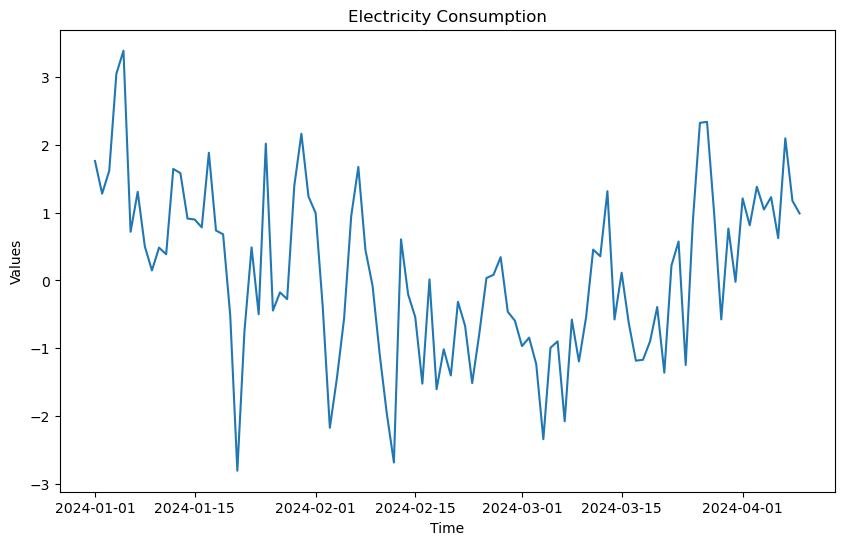

In [153]:
#Plot the time series
time_series(electricity_consumption.index,electricity_consumption['Electricity Consumption'],'Electricity Consumption','Time','Values')

#### Time interval decision
As there is no given time in the data, it is up to us to decide what a reasonable guess would be for the interval. It is fair to instantly ignore the possibility of it being a yearly measurement as the amount of electricity that is consumed now would trump the amount consumed 100 years ago. So it is between a weekly and a monthly basis. I am going to decompose for a weekly basis and a monthly basis. Looking at the seasonality pattern should be able to represent real world situations. 

#### Daily recordings
This would assume that the electricity consumption is recorded for a given day and you would want a seasonality based on the week (7). Look at the seasonality pattern and see if it makes sense

In [154]:
#Decompose the data into its individual parts, these can be accessed by indexing through the results
#[0] - Original
#[1] - Trend
#[2] - Seasonal
#[3] - Residual
weekly_electricity_consumption_decomposition = decompose_seasonality(electricity_consumption['Electricity Consumption'],7)

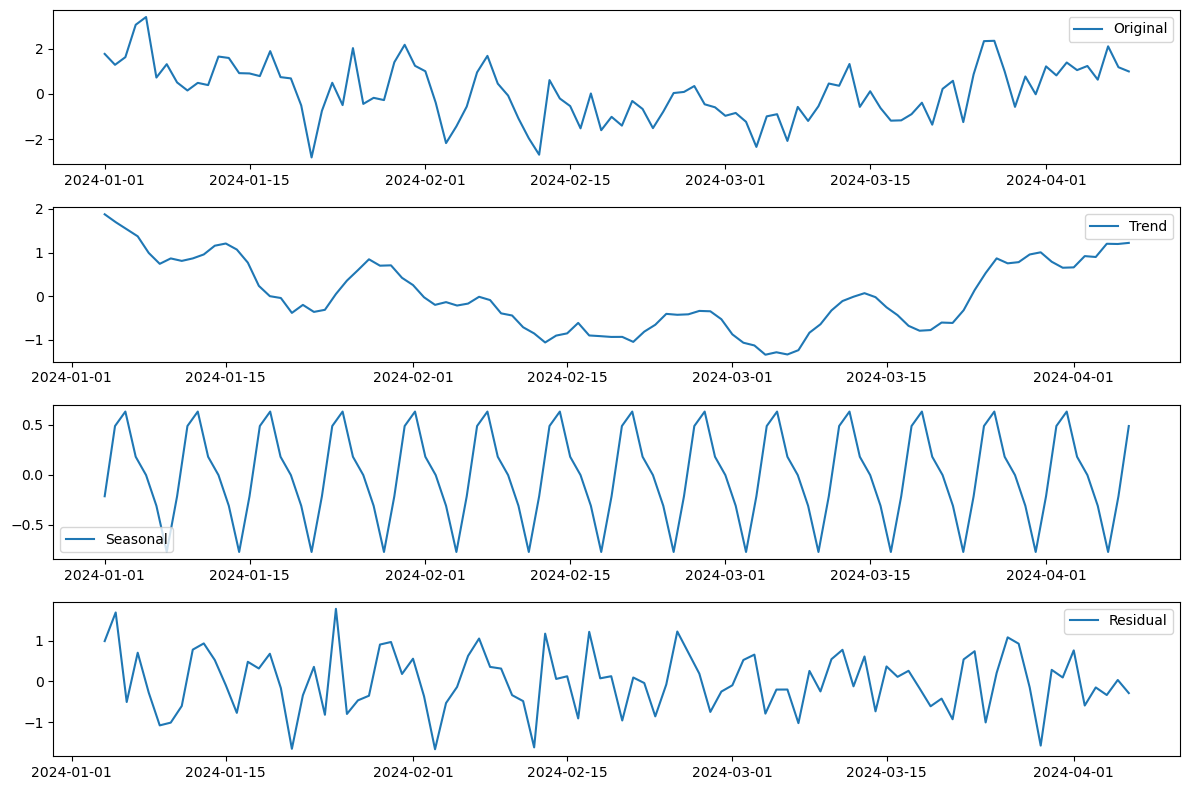

In [155]:
#Plot the electricity consumption seasonal decomposition
plot_seasonal_decomposition(electricity_consumption['Electricity Consumption'],7)

#### Weekly seasonality decomposition
Trend - There is no overall change in average values in the time series

Cycles - There is a downturn during the beginning of February which continues until the middle of March before returning to similar higher levels as seen at the start of the year. This could be due to the nicer weather that takes place during February and March that does not require A/C or a heater. Where as in January you might be using a heater to come the house warm while the AC might be turned as you head into April due to warmer temperatures.

Seasonality - There is a constant seasonality which has a period of peaks with a downturn which is going by a quick increase to the peak, which takes place within the weekly season

Residual - The residual as a constant mean around 0 with white noise

#### Seasonality Decomposition of Stock Prices

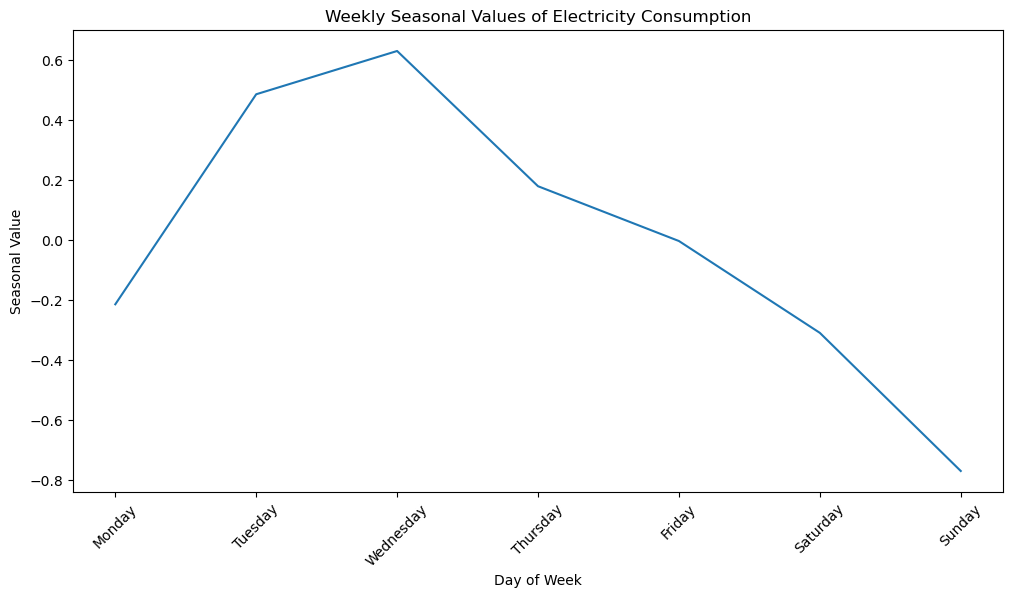

In [156]:
#plot the seasonal values on a graph so that you can understand which days have higher electricity consumed
days_column=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
seasonal_values_plot(weekly_electricity_consumption_decomposition[2],7,'seasonal',
                     'Weekly Seasonal Values of Electricity Consumption','Day of Week',days_column,'Seasonal Value')

#### Weekly Seasonal Values
The seasonal values show a peak during the working week with drops on Saturday and Sunday. This might suggest that it represents some work place where the weekends have a much smaller number of people that are working and therefore the amount fo electricity that is used is going to be much smaller. Where as during the week the electricity is higher. This would make logical sense for the period to be week.

#### Monthly recordings
This would imply that the recordings occured at the end of each month. The seasonality would reflect how the values change from month to month. 


In [157]:
#Change the index of electricity consumption to months rather than day
electricity_consumption['Month'] = pd.date_range('2015-01-01',periods=len(electricity_consumption),freq='MS')
electricity_consumption.set_index('Month',inplace=True)
electricity_consumption

,Electricity Consumption,Incrementing Day
Month,,
2015-01-01,1.764052,1
2015-02-01,1.282183,2
2015-03-01,1.619830,3
2015-04-01,3.050808,4
2015-05-01,3.392962,5
...,...,...
2022-12-01,1.230737,96
2023-01-01,0.625869,97
2023-02-01,2.098805,98


In [158]:
#Monthly electricity consumption decomposition
monthly_electricity_consumption_decomposition = decompose_seasonality(electricity_consumption['Electricity Consumption'],12)

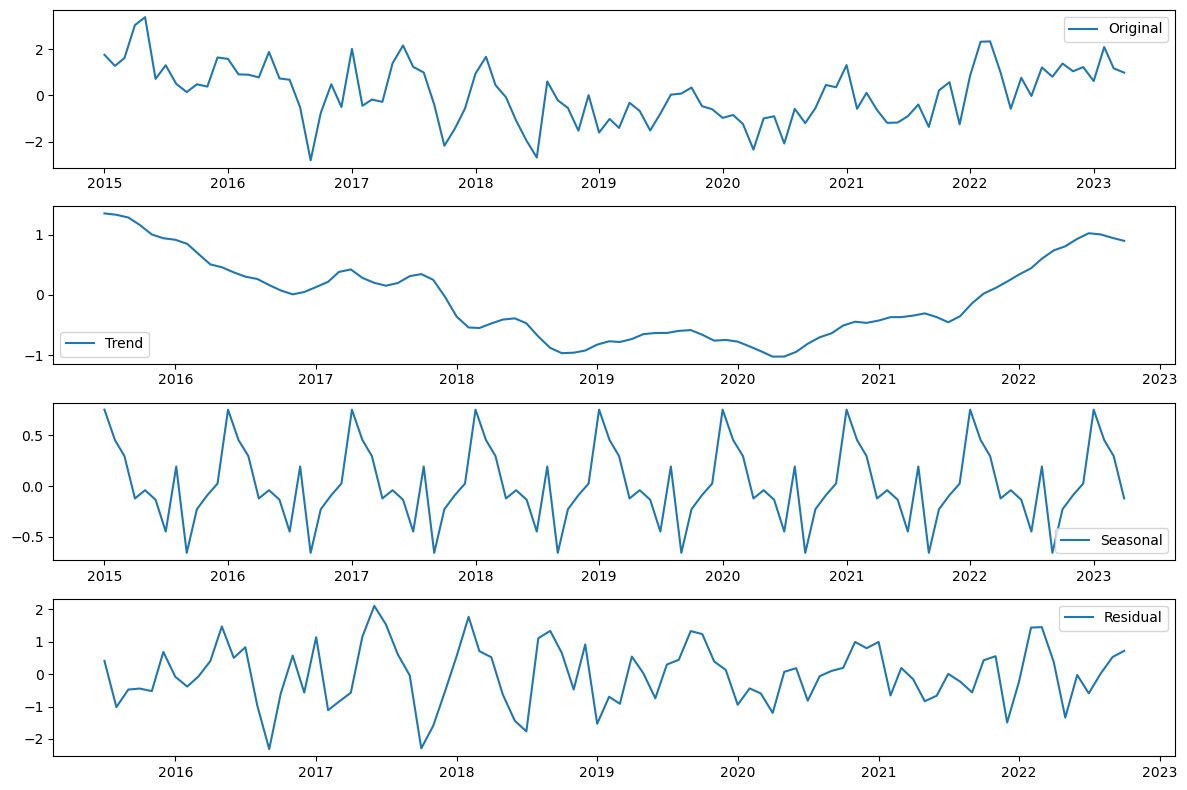

In [159]:
#Plot the electricity consumption which has a lag of 12 which would represent the months of the year
plot_seasonal_decomposition(electricity_consumption['Electricity Consumption'],12)

Monthly interval - This shows less of a consistient seasonal pattern and has spikes and dips. This would not reflect what would be expected when looking at monthly electricity consumption as it is assumed that there is a strong correlation with weather which changes more smoothly. 

Trend - There is no overall change in the average values in the time series.

Cycle - There is a cycle that takes place where there is a drop from 2018 to 2021 before 2022 and 2023 returns to values similar to 2016. This does not make a while lot of sense because it is assumed that the amount of electricity that was used during 2020 and 2021 would be far higher due to the Covid-19 Pandemic which took place due to the number of people that had to stay inside.

Seasonality - This seasonality does not follow as clear of a gradual change as it did with the weekly values

Residual - The residual values also seem to be larger

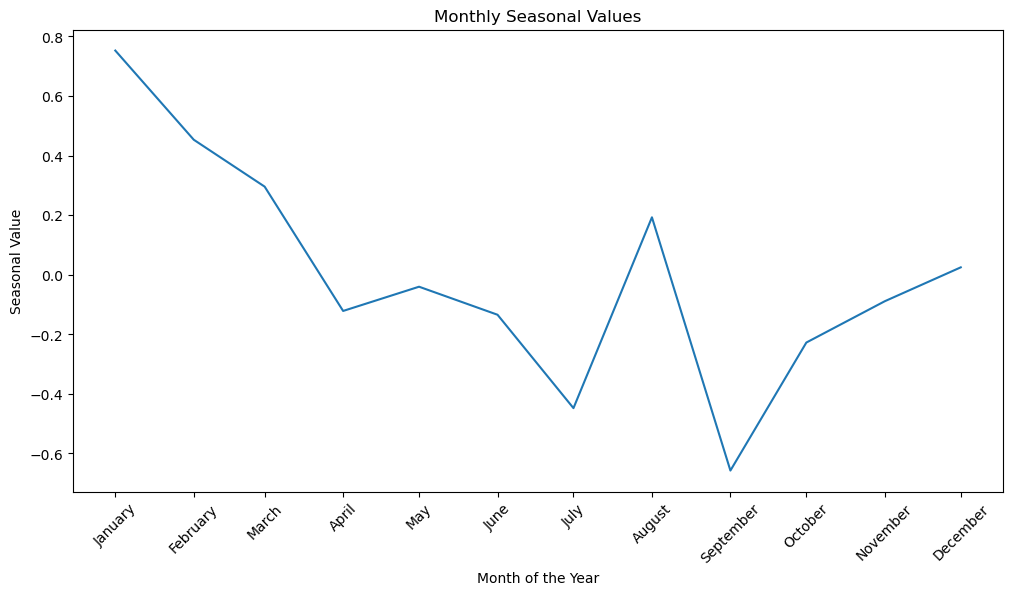

In [160]:
#Create the months of the year list
months_list = ['January','February','March','April','May','June','July','August','September','October','November','December']

#Plot the seasonal monthly values graph
seasonal_values_plot(monthly_electricity_consumption_decomposition[2],12,'seasonal',
                     'Monthly Seasonal Values','Month of the Year',months_list,'Seasonal Value')

#### Monthly Seasonal Values
Using months as the seasonal value it shows that January is the peak with decreasing values to July until a sudden spike up in August before leveling out in October through December. This does not follow as clear of a pattern as it does with the weekly seasonal values. 

#### Mean Absolute Error
This value will give you the average distance that the residuals are from the line of zero. The most accurate seasonal decomposition has residuals of 0, so the residual with the smallest mean absolute error is going to reflect a more accurate depiction of the movement of the data. Comparing the weekly and the monthly should also give better insight into which is better to use for the time interval

In [161]:
#MAE for using the period as week
weekly_electricity_consumption_decomposition[3].dropna(inplace=True)
zeros = np.zeros(len(weekly_electricity_consumption_decomposition[3]))
mean_absolute_error(zeros, weekly_electricity_consumption_decomposition[3]) 

0.5925758047097736

In [162]:
#MAE for using the period as month
monthly_electricity_consumption_decomposition[3].dropna(inplace=True)
zeros_88 = np.zeros(len(monthly_electricity_consumption_decomposition[3]))
mean_absolute_error(zeros_88,monthly_electricity_consumption_decomposition[3])

0.7489559703540682

#### Weekly or Monthly for time interval?
Weekly electricity is going to be the correct interval that is used for the time series due to the behavior of the seasonality, understanding of real world events and the lower mean absolute error.

### Preliminary Analysis
- Descriptive Statistics: Compute and interpret the mean, median, variance, and standard deviation for each dataset.

In [163]:
#Create a day column for electricity consumption and make that the index
#Remember that it was last used as month
electricity_consumption['Day'] = pd.date_range(start='2024-01-01', periods=len(electricity_consumption), freq='D')
electricity_consumption.set_index('Day',inplace=True)
electricity_consumption

,Electricity Consumption,Incrementing Day
Day,,
2024-01-01,1.764052,1
2024-01-02,1.282183,2
2024-01-03,1.619830,3
2024-01-04,3.050808,4
2024-01-05,3.392962,5
...,...,...
2024-04-05,1.230737,96
2024-04-06,0.625869,97
2024-04-07,2.098805,98


In [164]:
#Create a new dataframe that is in weekly data
#This is done so that you can look at the different statistical information easier
#You can look at these statistics based on their week and also on their day of the week
electricity_consumption_weekly = create_weekly_data(electricity_consumption,'Electricity Consumption','Incrementing Day')
electricity_consumption_weekly

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,1.764052,1.282183,1.61983,3.050808,3.392962,0.719203,1.30969
1,0.503488,0.148525,0.484861,0.386474,1.647511,1.584793,0.914072
2,0.900899,0.784124,1.886141,0.737912,0.682024,-0.513084,-2.809532
3,-0.751147,0.488863,-0.497734,2.020888,-0.443922,-0.176202,-0.275285
4,1.395137,2.166927,1.238411,0.997368,-0.389102,-2.175347,-1.435586
5,-0.561444,0.949569,1.677164,0.451255,-0.076675,-1.086891,-1.963463
6,-2.688002,0.606775,-0.206265,-0.541207,-1.523399,0.015791,-1.606002
7,-1.015741,-1.403337,-0.314766,-0.668188,-1.514726,-0.785545,0.035559
8,0.084297,0.34462,-0.462012,-0.593747,-0.969334,-0.84422,-1.235256
9,-2.343911,-0.994529,-0.899046,-2.079721,-0.577078,-1.195838,-0.545973


#### NaN Values Solutions
There are missing values in week 14 and there are a few ways to overcome this problem
1. Remove week 14, as there are only 2 real data values it might be smart to remove this week to ensure data integrity
2. Replace with mean of values, replace the NaN with the mean of the first 13 weeks - going to work when there is no overall trend
3. Replace most recent value - going to work when there is an overall trend to the data

For this dataset, replace the Nan values with the mean

In [165]:
#Find the average from weeks 1-14 and then replace na with those values
days_replace = ['Wednesday','Thursday','Friday','Saturday','Sunday']
missing_values_replace(days_replace,electricity_consumption_weekly,0,14)

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,1.764052,1.282183,1.61983,3.050808,3.392962,0.719203,1.30969
1,0.503488,0.148525,0.484861,0.386474,1.647511,1.584793,0.914072
2,0.900899,0.784124,1.886141,0.737912,0.682024,-0.513084,-2.809532
3,-0.751147,0.488863,-0.497734,2.020888,-0.443922,-0.176202,-0.275285
4,1.395137,2.166927,1.238411,0.997368,-0.389102,-2.175347,-1.435586
5,-0.561444,0.949569,1.677164,0.451255,-0.076675,-1.086891,-1.963463
6,-2.688002,0.606775,-0.206265,-0.541207,-1.523399,0.015791,-1.606002
7,-1.015741,-1.403337,-0.314766,-0.668188,-1.514726,-0.785545,0.035559
8,0.084297,0.34462,-0.462012,-0.593747,-0.969334,-0.84422,-1.235256
9,-2.343911,-0.994529,-0.899046,-2.079721,-0.577078,-1.195838,-0.545973


#### Finding mean, standard deviation, median and variance

In [166]:
#Create mean, median, std and variance for days of week and each week
electricity_consumption_statistics = mean_median_variance_std_weekly(electricity_consumption_weekly,days_column)
electricity_consumption_statistics

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekly Mean,Weekly Median,Standard Deviation,Variance
0,1.764052,1.282183,1.61983,3.050808,3.392962,0.719203,1.30969,1.876961,1.619830,0.980731,0.961833
1,0.503488,0.148525,0.484861,0.386474,1.647511,1.584793,0.914072,0.809960,0.503488,0.595700,0.354858
2,0.900899,0.784124,1.886141,0.737912,0.682024,-0.513084,-2.809532,0.238355,0.737912,1.513974,2.292117
3,-0.751147,0.488863,-0.497734,2.020888,-0.443922,-0.176202,-0.275285,0.052209,-0.275285,0.950417,0.903292
4,1.395137,2.166927,1.238411,0.997368,-0.389102,-2.175347,-1.435586,0.256830,0.997368,1.615193,2.608849
5,-0.561444,0.949569,1.677164,0.451255,-0.076675,-1.086891,-1.963463,-0.087212,-0.076675,1.239796,1.537095
6,-2.688002,0.606775,-0.206265,-0.541207,-1.523399,0.015791,-1.606002,-0.848901,-0.541207,1.139063,1.297464
7,-1.015741,-1.403337,-0.314766,-0.668188,-1.514726,-0.785545,0.035559,-0.809535,-0.785545,0.558562,0.311992
8,0.084297,0.34462,-0.462012,-0.593747,-0.969334,-0.84422,-1.235256,-0.525093,-0.593747,0.568620,0.323329
9,-2.343911,-0.994529,-0.899046,-2.079721,-0.577078,-1.195838,-0.545973,-1.233728,-0.994529,0.709820,0.503845


The dataframe above includes the mean, median, variance and standard deviation for the days of the week and the for the incrementing weeks. This allows for two different types of understanding. The daily values gives an idea of what seasonality takes place on certain days while the weekly values helps understand the trend of the data. Looking at the overall trend is more important for this data so that is what is going to be looked at in the section below.

#### Weekly Mean for Electricity Consumption

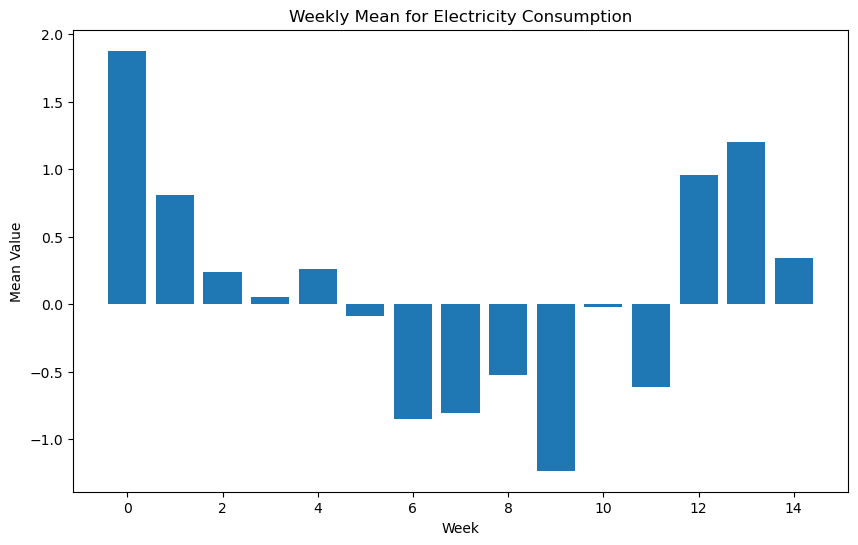

In [167]:
#Create a bar chart of the mean of the values of weeks 1-15
bar_chart(electricity_consumption_statistics.index[0:15],electricity_consumption_statistics['Weekly Mean'][0:15],'Weekly Mean for Electricity Consumption','Week','Mean Value')

There is a clear pattern that is similar to the trend that is observed for the trend of electricity consumption data. Earlier weeks and later weeks show an increase in amount of electricity used while there is a smaller amount of electricity that is used around the middle portion of the data.

#### Weekly Median for Electricity Consumption

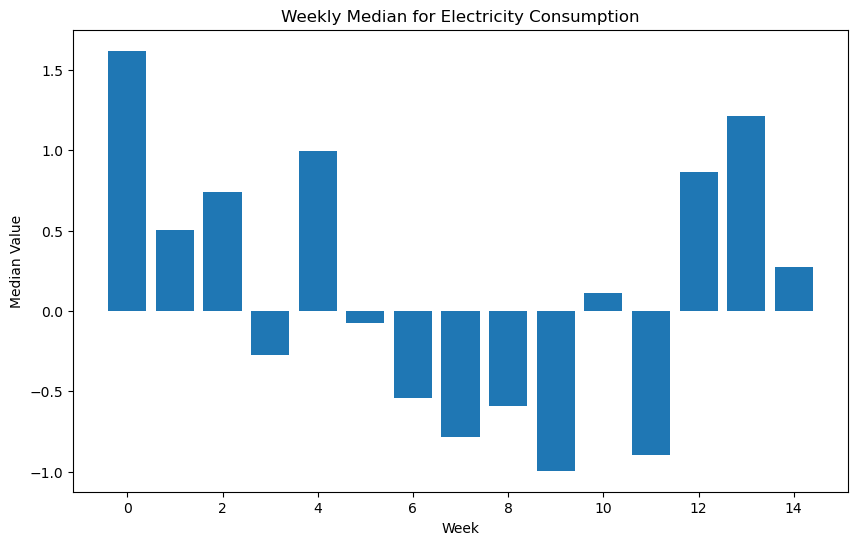

In [168]:
#Create a bar chart of the weekly median of weeks 1-15
bar_chart(electricity_consumption_statistics.index[0:15],electricity_consumption_statistics['Weekly Median'][0:15],'Weekly Median for Electricity Consumption','Week','Median Value')

The mean and the median seem to follow a simialr trend where the initial and end of the data is positive while the middle is negative. However there are certain weeks which have far different mean values vs median, such as week 4 which has a much higher median than the mean while implies that the variance is higher.

#### Weekly Variance for Electricity Consumption

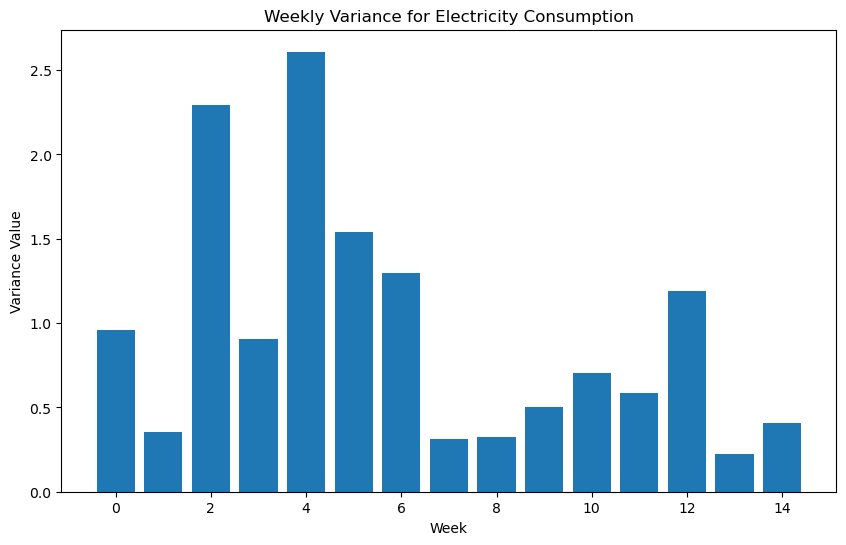

In [169]:
#Plot the bar chart for variance of the values (daily values) from weeks 1-15
bar_chart(electricity_consumption_statistics.index[0:15],electricity_consumption_statistics['Variance'][0:15],'Weekly Variance for Electricity Consumption','Week','Variance Value')

The variance has a positively skewed distribution. This means that if you were to look at the values across the weeks, the values in the earlier weeks have more oscillations in their values. This can be observed by looking at the residuals from the seasonal decomposition.

#### Weekly Standard Deviation for Electricity Consumption

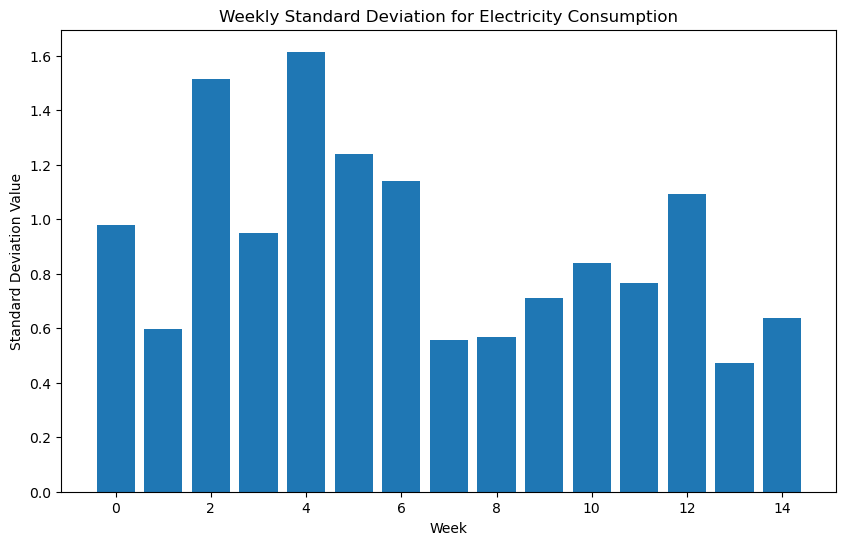

In [170]:
#Plot the standard deviation of the values (daily values) from weeks 1-15
bar_chart(electricity_consumption_statistics.index[0:15],electricity_consumption_statistics['Standard Deviation'][0:15],'Weekly Standard Deviation for Electricity Consumption','Week','Standard Deviation Value')

Standard deviation further proves that there is no clear pattern as the difference between higher and smaller values is flattened out. Standard deviation is preferred as it is experessed in the same units as the original data. 

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### Components of Box-Jenkins Models
- p: Autoregressive (AR) order for non-seasonal component.

- d: Differencing order for non-seasonal component.

- q: Moving average (MA) order for non-seasonal component.

- P: Autoregressive (AR) order for seasonal component.

- D: Differencing order for seasonal component.

- Q: Moving average (MA) order for seasonal component.

- s: Seasonal period (e.g., 12 for monthly data, 4 for quarterly data).

#### AIC Model Explanation
- Formulation: AIC is calculated as 2k - 2ln(L), where k is the number of paramters and ln(L) is the log of the likelihood model
- Purpose: AIC selets a model that is most accurate in underlying mechanisms that generates the observed data
- Penalty for complexity: It penalises the complexity based on the number of parameters
- Assumption: Does not require assumptions

#### BIC Model Explanation
- Formulation: BIC = ln(n)k - 2ln(L) where n is the same size and k is the number of parameters, and ln(L) is the log likelihood
- Purpose: aims to select the most true model based on certain assumptions
- Penalty: BIC places penalty on number of parameters in the model, more than in AIC
- Assumption: BIC is derived from Bayesian probability

AIC is focused on identifying models that closely represent the data while BIC is using assumptions to understand the true model.

#### q for Electricity Consumption

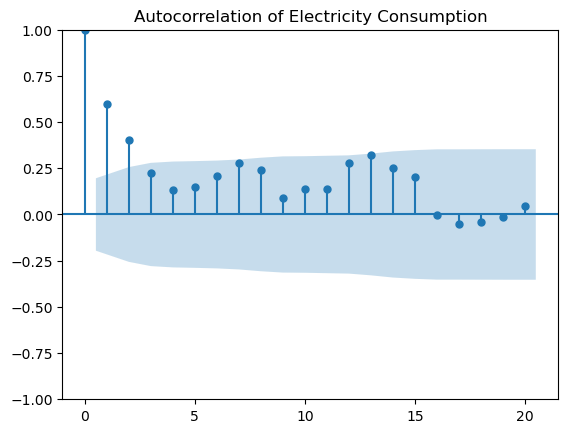

In [171]:
#Plot the ACF values
acf_values_electricity_consumption = plot_acf(electricity_consumption['Electricity Consumption'],lags=20,title='Autocorrelation of Electricity Consumption')

In [172]:
#Orders for q
q_orders_electricity_consumption = [1,2,7,13]

#### p Order for Electricity Consumption

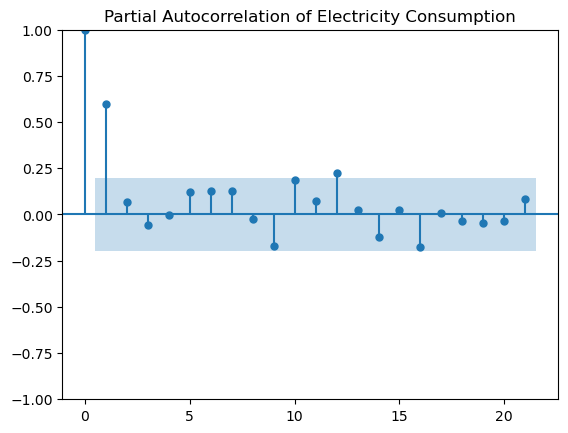

In [173]:
#Plot the PACF values
pacf_values_electricity_consumption = plot_pacf(electricity_consumption['Electricity Consumption'],lags=21,title='Partial Autocorrelation of Electricity Consumption')

In [174]:
#Potential AR (p) order
p_orders_electricity_consumption = [1,9,11]

#### d Order for Electricity Consumption

In [175]:
#Determine the stationarity of electricity consumption
adf_test(electricity_consumption['Electricity Consumption'])

ADF Statistic:  -4.978224856580164
P-Value:  2.450404893865566e-05
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


The ADF statistic shows that there is no need to difference the data as it is above the 99% confidence interval

In [176]:
#d order for stationarity
d_order_electricity_consumption = [0,1]

#### Removing Seasonality from data for P,D,Q
In trying to find the values for the SARIMA model, you have to remove the seasonality from original data. This creates seasonally adjusted data which is used for the sarima model. Once this has been done create an ACF and PACF plot and look for potential P,D,Q values.

In [177]:
#Create the series for electricity consumption that has removed the seasonality values from the original values
weekly_electricity_consumption_seasonal_removed = weekly_electricity_consumption_decomposition[0] - weekly_electricity_consumption_decomposition[2]
weekly_electricity_consumption_seasonal_removed

Day
2024-01-01    1.978450
2024-01-02    0.795224
2024-01-03    0.988383
2024-01-04    2.870932
2024-01-05    3.396079
                ...   
2024-04-05    1.233855
2024-04-06    0.935644
2024-04-07    2.869796
2024-04-08    1.390712
2024-04-09    0.503188
Length: 100, dtype: float64

#### Q order for Electricity Consumption

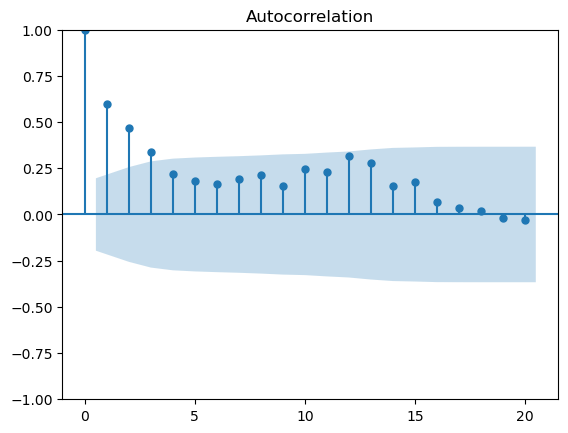

In [178]:
#Plot the new acf 
acf_values_electricity_consumption_seasonally_adjusted = plot_acf(weekly_electricity_consumption_seasonal_removed)

In [179]:
#Orders for Q
Q_orders_electricity_consumption = [1,2,3,12,13]

#### P Order for Electricity Consumption

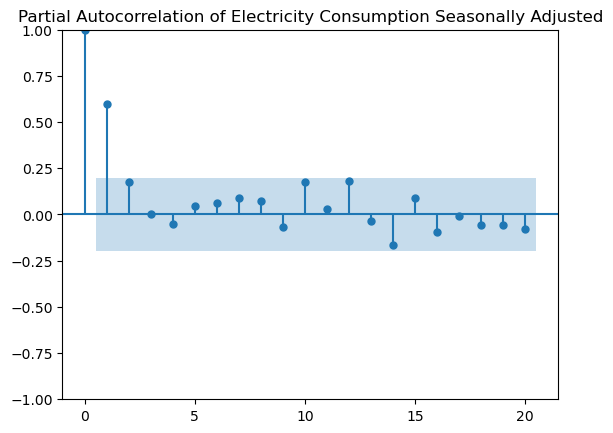

In [180]:
#Plot the PACF values
pacf_values_electricity_consumption_seasonally_adjusted = plot_pacf(weekly_electricity_consumption_seasonal_removed,lags=20,
                                                                    title='Partial Autocorrelation of Electricity Consumption Seasonally Adjusted')

In [181]:
#Orders for P
P_orders_electricity_consumption = [1,2,10,12,14]

#### D Order for Electricity Consumption

In [182]:
adf_test(weekly_electricity_consumption_seasonal_removed)

ADF Statistic:  -3.6626097320270086
P-Value:  0.00467090061942871
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [183]:
D_order_electricity_consumption = [0,1]

#### Parameters for Box Jenkins Models
- q: 1,2,7,13
- p: 1,9,11
- d: 0,1
- Q: 1,2,3,12,13
- P: 1,2,10,12,14
- D: 0,1
- s: 7

#### AR Model Selection

In [184]:
#Find the best AR model
#Returns p 
select_best_ar_model(electricity_consumption['Electricity Consumption'],p_orders_electricity_consumption)

{'best_aic': 289.0833594045243,
 'best_aic_model': 1,
 'best_bic': 296.89886996248856,
 'best_bic_model': 1}

#### MA Model Selection

In [185]:
#Find the best MA model
#Returns q
select_best_ma_model(electricity_consumption['Electricity Consumption'],q_orders_electricity_consumption)

{'best_aic': 294.6442220137474,
 'best_aic_model': 2,
 'best_bic': 305.06490275769977,
 'best_bic_model': 2}

#### ARMA Model Selection

In [186]:
#Find the ARMA 
#Returns p,q
select_best_arma_model(electricity_consumption['Electricity Consumption'],p_orders_electricity_consumption,q_orders_electricity_consumption)

{'best_aic': 284.58319475131304,
 'best_aic_model': (11, 1),
 'best_bic': 303.9486818228041,
 'best_bic_model': (1, 1)}

#### ARIMA Model Selection

In [187]:
#Find the ARIMA
#Returns p,d,q
select_best_arima(electricity_consumption['Electricity Consumption'],p_orders_electricity_consumption,q_orders_electricity_consumption,d_order_electricity_consumption)

{'best_aic': 285.5966269362885,
 'best_aic_model': (1, 1, 1),
 'best_bic': 293.38198648669226,
 'best_bic_model': (1, 1, 1)}

#### SARIMA Model Selection

In [253]:
#Find best SARIMA 
#Returns p,d,q
#Returns P,D,Q,s
select_best_sarima_model(electricity_consumption['Electricity Consumption'],p_orders_electricity_consumption,d_order_electricity_consumption,q_orders_electricity_consumption,P_orders_electricity_consumption,D_order_electricity_consumption,Q_orders_electricity_consumption,7)

{'aic': 285.714666551609,
 'bic': 293.5301771095733,
 'pdq': (1, 0, 0),
 'seasonal_pdq': (1, 0, 0, 7)}

#### Best Model Selection
##### AR Model
AIC : 289,
p : 1

BIC : 296.9,
p : 1

##### MA Model
AIC : 294.64,
q : 2

BIC : 305,
q : 2

##### ARMA Model
AIC : 284.58,
p : 11,
q : 1

BIC : 285.6,
p : 1,
q : 1

##### ARIMA Model
AIC : 285.59,
p : 1,
d : 1,
q : 1

BIC : 293.38,
p : 1,
d : 1,
q : 1

##### SARIMA Model
AIC : 285.71

BIC : 293.53

p : 1,
d : 0,
q : 0,
P : 1,
D : 0,
Q : 0,
s : 7

## Stock Prices
The stock prices dataset includes a column that says daily stock prices. This is going to be the reason for using a weekly seasonality as there is not enough data values to look at seasonality for each day of the month (30) or year (365).

### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [189]:
#Load in the stock prices dataset
stock_prices = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Stock Prices')

In [190]:
#Preprocess stock prices
#Remove the unnecessary column and create a datetime series which will be in the index
stock_prices['Day'] = pd.date_range('2024-01-01',periods=len(stock_prices))
stock_prices.drop(columns='Unnamed: 0',inplace=True)
stock_prices.set_index('Day',inplace=True)
stock_prices['Incrementing Day'] = range(1, len(stock_prices)+1)
stock_prices

,Daily Stock Prices,Incrementing Day
Day,,
2024-01-01,1.883151,1
2024-01-02,-0.406184,2
2024-01-03,-1.944365,3
2024-01-04,0.334154,4
2024-01-05,-0.688425,5
...,...,...
2024-04-05,0.090092,96
2024-04-06,0.686017,97
2024-04-07,1.209399,98


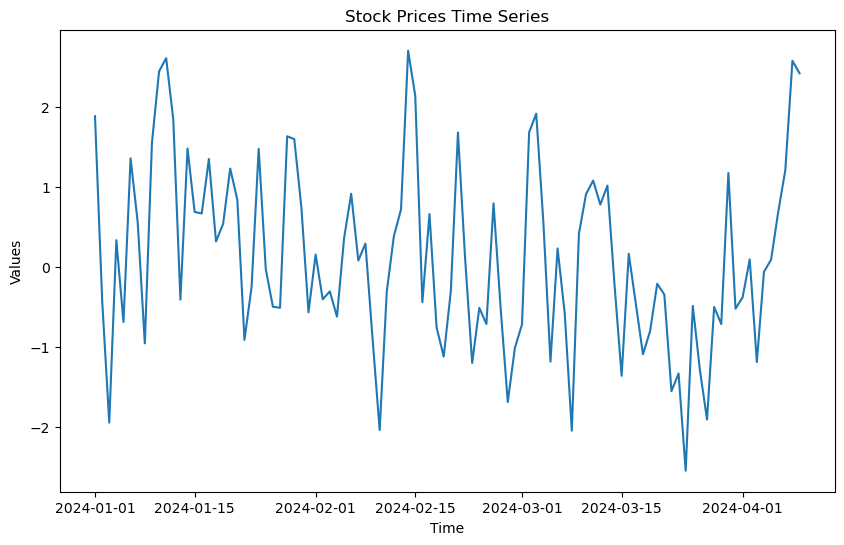

In [191]:
#Plot the time series of stock prices
time_series(stock_prices.index,stock_prices['Daily Stock Prices'],'Stock Prices Time Series','Time','Values')

#### Time Interval Decision
Stock prices are recorded always as daily. There is another factor in that weekend dates are usually not recorded so the lag is going to be 5. This is assuming that the weekend values have not been recorded as there are no NA values.

In [192]:
#Decompose the data into its individual parts, these can be accessed by indexing through the results
weekly_stock_prices_decomposition = decompose_seasonality(stock_prices['Daily Stock Prices'],5)

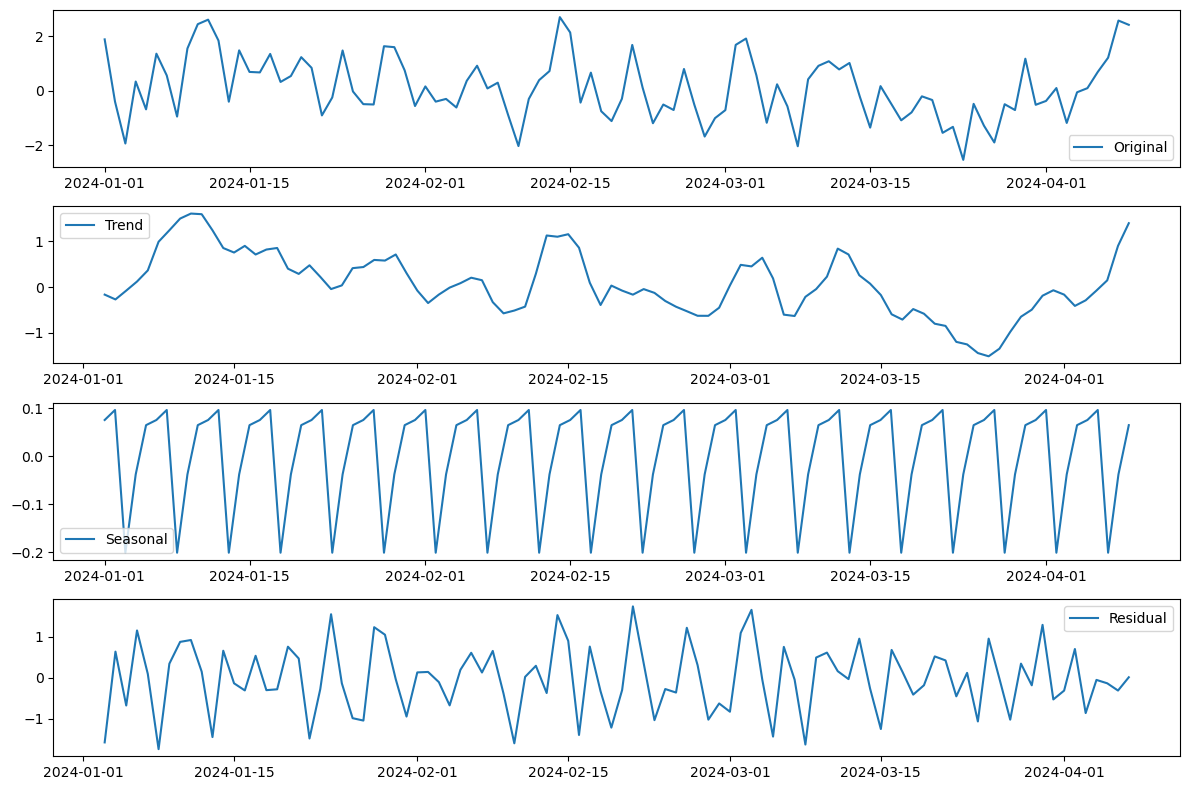

In [193]:
#Plot the stock prices seasonal decomposition
plot_seasonal_decomposition(stock_prices['Daily Stock Prices'],5)

#### Weekly seasonality decomposition
Trend - There seems to be some decreasing line, this can be explored with a line of best fit

Cycles - There are some periods of increases but nothing that is worth noticing.

Seasonality - It shows that there are values that are higher with one value that shrinks downwards to a much smaller value. However the seasonality values are quite small at -0.2 and +0.1.

Residual - The residual value has a mean around 0 with white noise fluctuations

#### Trend Decomposition of Stock Prices

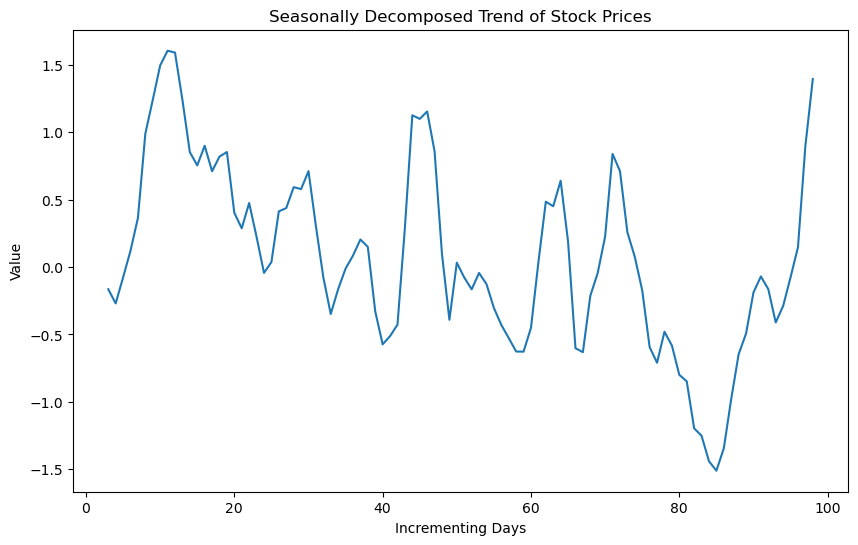

In [194]:
#Plot the line of best fit through the trend to see the downards trend
time_series(stock_prices['Incrementing Day'],weekly_stock_prices_decomposition[1],'Seasonally Decomposed Trend of Stock Prices','Incrementing Days','Value')

#### Line of Best Fit for Stock Prices

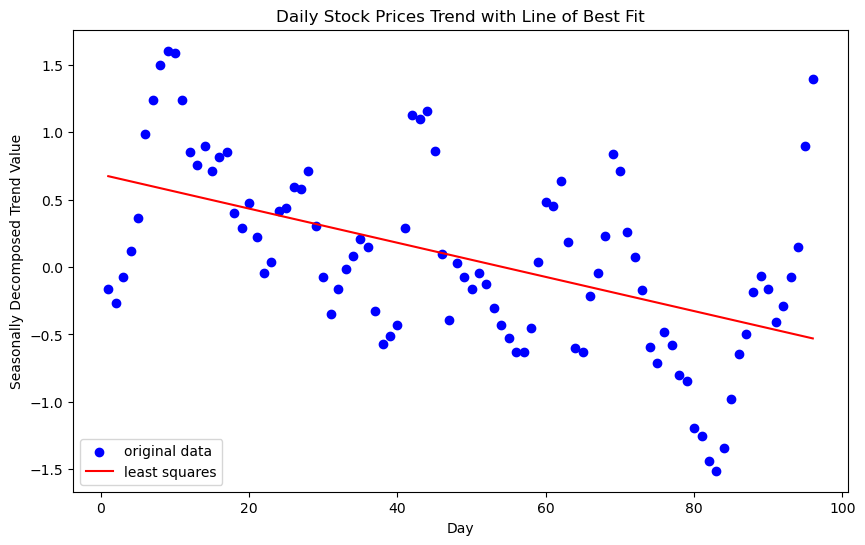

In [195]:
#Plot line of best fit against trend data
weekly_stock_prices_decomposition[1].dropna(inplace=True)
plot_least_squares_line(stock_prices['Incrementing Day'][0:96],weekly_stock_prices_decomposition[1],'Daily Stock Prices Trend with Line of Best Fit','Day','Seasonally Decomposed Trend Value')

#### Line of Best Fit of Trend after Decomposition
There is a clear decreasing trend, after the decomposition has taken place, this is suggesting that the stock price is decreasing overtime

#### Seasonality Decomposition of Stock Prices

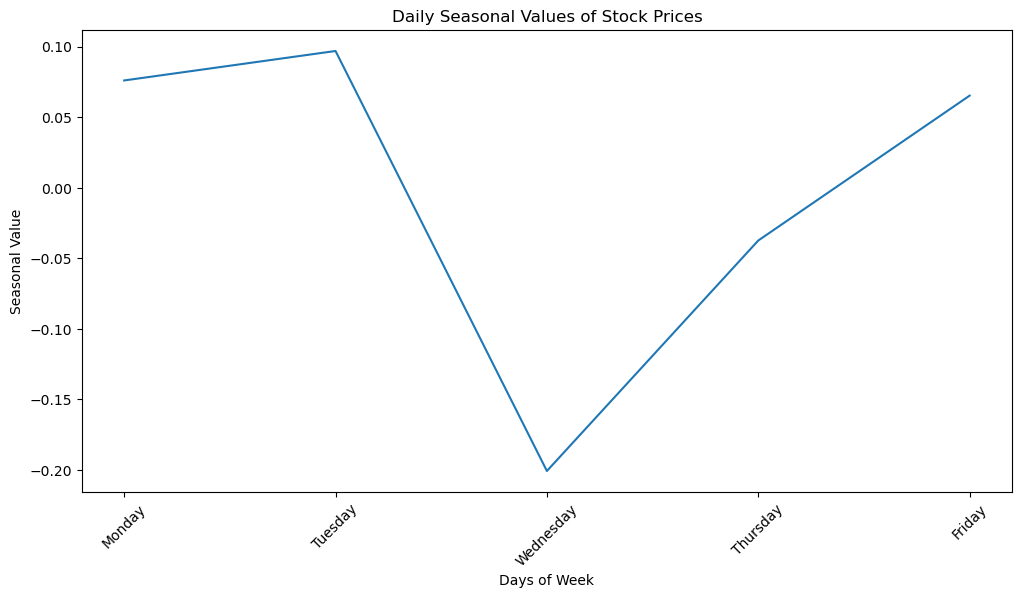

In [196]:
day_of_week_column = ['Monday','Tuesday','Wednesday','Thursday','Friday']
seasonal_values_plot(weekly_stock_prices_decomposition[2],5,'seasonal','Daily Seasonal Values of Stock Prices',
                     'Days of Week',day_of_week_column,'Seasonal Value')

#### Seasonal Values of Stock Prices
The value of the stock does not have too much dependence on the day of the week. This is established by the small seasonal values (0.3 total range). Wednesday has the biggest drop, while the other values are much higher relatively.

#### Mean Absolute Error for Daily Stock Prices

In [197]:
#MAE for Stock Prices
weekly_stock_prices_decomposition[3].dropna(inplace=True)
zeros_94 = np.zeros(len(weekly_stock_prices_decomposition[3]))
mean_absolute_error(zeros_94,weekly_stock_prices_decomposition[3])

0.6525406453688252

This mean absolute error is slightly higher than the value for electricity consumption which means that the residuals on average are further from the ideal residual line of 0.

### Preliminary Analysis
- Descriptive Statistics: Compute and interpret the mean, median, variance, and standard deviation for each dataset.

In [198]:
#Create a new dataframe that looks at the week day
stock_prices_weekly = create_week_day_data(electricity_consumption,'Electricity Consumption','Incrementing Day')
stock_prices_weekly

,Monday,Tuesday,Wednesday,Thursday,Friday
0,1.764052,1.282183,1.61983,3.050808,3.392962
1,0.719203,1.30969,0.503488,0.148525,0.484861
2,0.386474,1.647511,1.584793,0.914072,0.900899
3,0.784124,1.886141,0.737912,0.682024,-0.513084
4,-2.809532,-0.751147,0.488863,-0.497734,2.020888
5,-0.443922,-0.176202,-0.275285,1.395137,2.166927
6,1.238411,0.997368,-0.389102,-2.175347,-1.435586
7,-0.561444,0.949569,1.677164,0.451255,-0.076675
8,-1.086891,-1.963463,-2.688002,0.606775,-0.206265
9,-0.541207,-1.523399,0.015791,-1.606002,-1.015741


There are no NaN values so there is no need to consider the options of replacing those missing values

#### Finding mean, standard deviation, median and variance

In [199]:
#Create mean, median, std and variance for days of week and each week
stock_prices_statistics = mean_median_variance_std_week_day(stock_prices_weekly,day_of_week_column)
stock_prices_statistics

,Monday,Tuesday,Wednesday,Thursday,Friday,Weekly Mean,Weekly Median,Standard Deviation,Variance
0,1.764052,1.282183,1.61983,3.050808,3.392962,2.221967,1.764052,0.937237,0.878414
1,0.719203,1.30969,0.503488,0.148525,0.484861,0.633153,0.503488,0.429760,0.184694
2,0.386474,1.647511,1.584793,0.914072,0.900899,1.086750,0.914072,0.528499,0.279311
3,0.784124,1.886141,0.737912,0.682024,-0.513084,0.715423,0.737912,0.849434,0.721538
4,-2.809532,-0.751147,0.488863,-0.497734,2.020888,-0.309732,-0.497734,1.771210,3.137183
5,-0.443922,-0.176202,-0.275285,1.395137,2.166927,0.533331,-0.176202,1.175124,1.380916
6,1.238411,0.997368,-0.389102,-2.175347,-1.435586,-0.352851,-0.389102,1.487475,2.212582
7,-0.561444,0.949569,1.677164,0.451255,-0.076675,0.487974,0.451255,0.873026,0.762174
8,-1.086891,-1.963463,-2.688002,0.606775,-0.206265,-1.067569,-1.086891,1.320424,1.743518
9,-0.541207,-1.523399,0.015791,-1.606002,-1.015741,-0.934112,-1.015741,0.682285,0.465512


The dataframe shows 19 weeks of Monday-Friday values. It follows the same format as per electricity consumption. Further analysis of the statistical data can be done to better understand. Again looking at mean, median, variance and standard deviation for the days of the week can be useful but understanding the overall data is going to be best to look at the incremental weeks.

#### Weekly Mean Value of Stock Prices

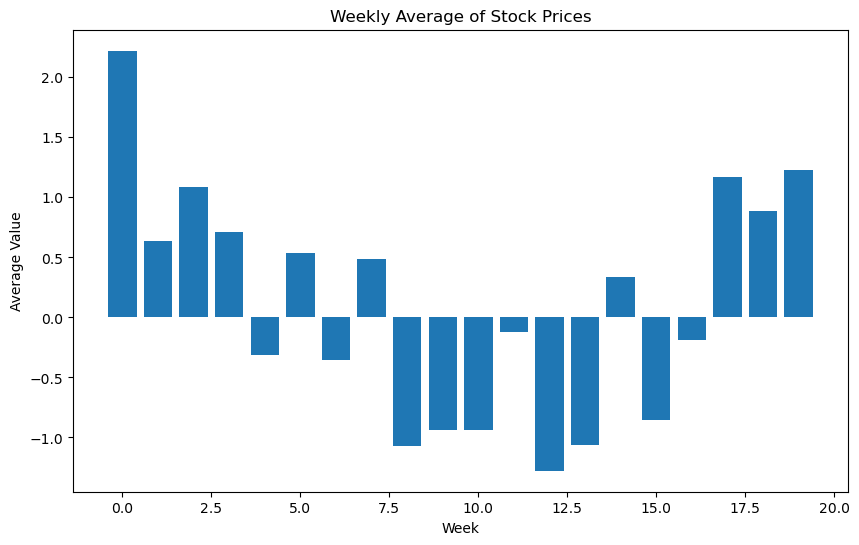

In [200]:
#Create the bar chart for weekly average of stock prices
bar_chart(stock_prices_statistics.index[0:20],stock_prices_statistics['Weekly Mean'][0:20],'Weekly Average of Stock Prices','Week','Average Value')

Similar to electricity consumption, this follows a similar trend to the line chart that is plot. As time goes on there is a movement from higher values to lower values before a sharp spike at the end of the data. However, this does prove that the dereasing trend can be observed by looking at average values and is not just the result of large fluctuations.

#### Weekly Median of Stock Prices

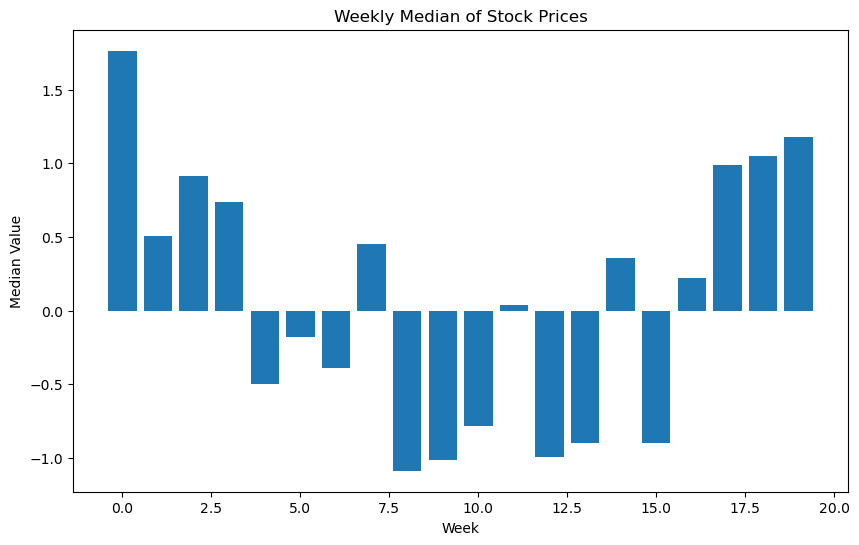

In [201]:
#Create the bar chart for median value of stock prices
bar_chart(stock_prices_statistics.index[0:20],stock_prices_statistics['Weekly Median'][0:20],'Weekly Median of Stock Prices','Week','Median Value')

The median displays a similar pattern to mean where the data starts high and decreases beofre a small return at the end of the data. This means that the spread across the days is quite small which is reflected in the seasonality being small.

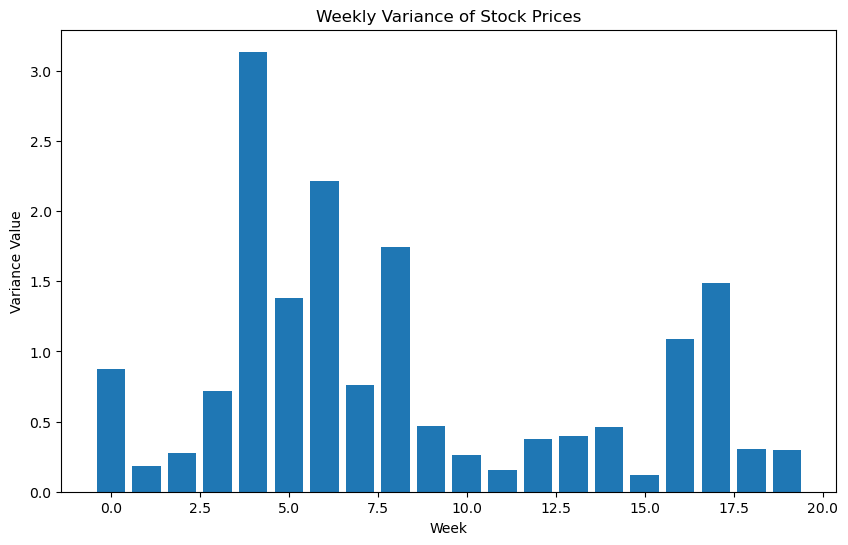

In [202]:
#Create the bar chart for variance of stock prices
bar_chart(stock_prices_statistics.index[0:20],stock_prices_statistics['Variance'][0:20],'Weekly Variance of Stock Prices','Week','Variance Value')

Variance is higher at the start of the stock prices and gets to be very small. This is presented by the residual values being higher at the start. As the higher the variance means that the model is going to be less accurate.

#### Standard Deviation of Stock Prices

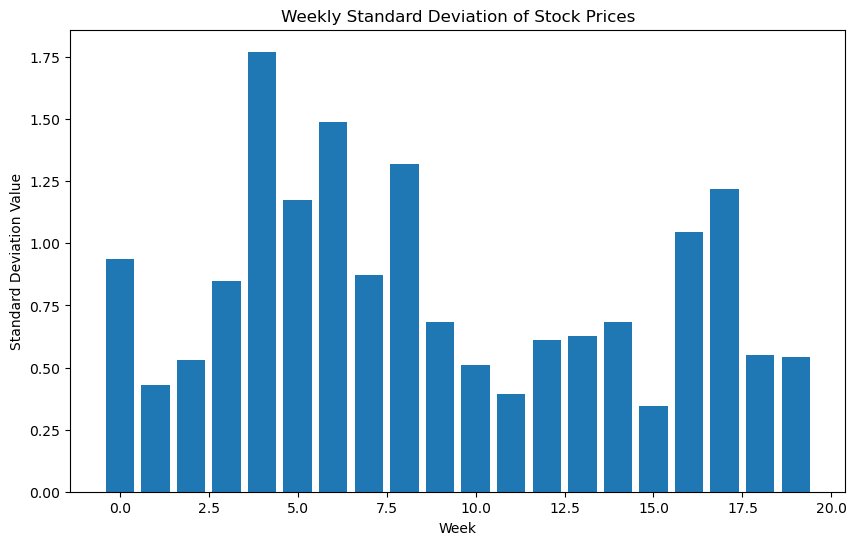

In [203]:
bar_chart(stock_prices_statistics.index[0:20],stock_prices_statistics['Standard Deviation'][0:20],'Weekly Standard Deviation of Stock Prices','Week','Standard Deviation Value')

The standard deviation gets the square root of the variance which shows a more symmetrical spread of where there is a greater distance from the mean. However it remains quite small which is reflected in a small MAE and seasonality not showing very high values

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### q Order for Stock Prices

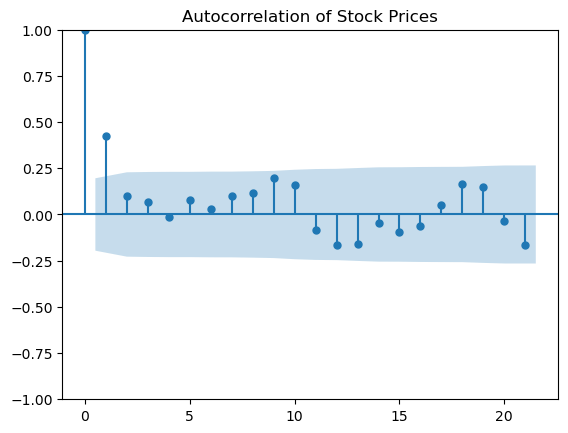

In [204]:
#Plot the ACF values
acf_values=plot_acf(stock_prices['Daily Stock Prices'],lags=21,title='Autocorrelation of Stock Prices')

In [205]:
#q Orders for Stock Prices
q_orders_stock_prices = [1,9,10]

#### p Order for Stock Prices

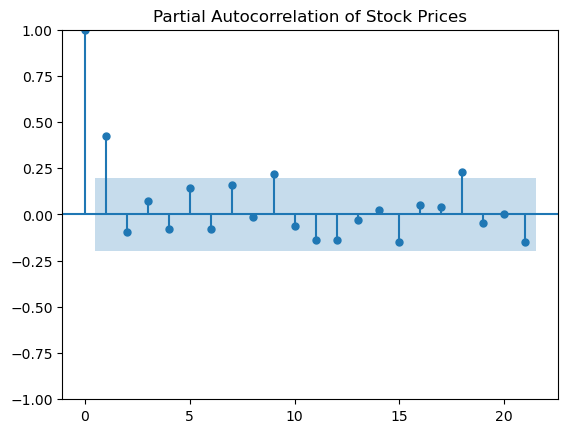

In [206]:
#Plot the PACF values
pacf_values=plot_pacf(stock_prices['Daily Stock Prices'],lags=21,title='Partial Autocorrelation of Stock Prices')

In [207]:
#p orders
p_orders_stock_prices = [1,17,9]

#### d Order for Stock Prices

In [208]:
#Test the stationarity of stock prices
adf_test(stock_prices['Daily Stock Prices'])

ADF Statistic:  -6.081858607650719
P-Value:  1.087386133417479e-07
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [209]:
#d orders
d_orders_stock_prices = [0,1]

#### Removing Seasonality from data for P,D,Q

In [210]:
#Create the new series which has seasonal components removed from the data
weekly_stock_prices_seasonally_removed = weekly_stock_prices_decomposition[0] - weekly_stock_prices_decomposition[2]
weekly_stock_prices_seasonally_removed

Day
2024-01-01    1.807161
2024-01-02   -0.503043
2024-01-03   -1.743689
2024-01-04    0.371561
2024-01-05   -0.753658
                ...   
2024-04-05    0.014103
2024-04-06    0.589158
2024-04-07    1.410075
2024-04-08    2.612395
2024-04-09    2.352913
Length: 100, dtype: float64

#### Q Order for Stock Prices

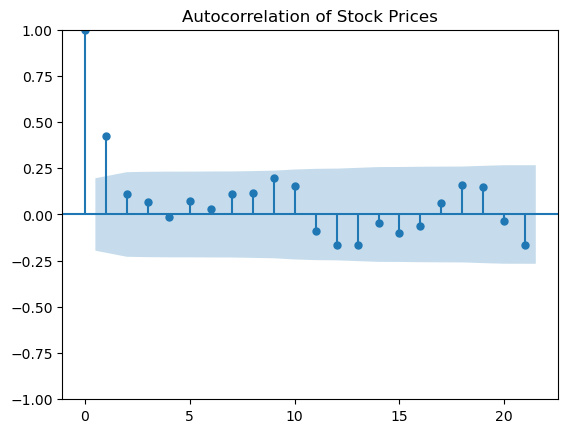

In [211]:
#Create acf plot of stock prices
acf_value_stock_prices = plot_acf(weekly_stock_prices_seasonally_removed, lags=21, title='Autocorrelation of Stock Prices')

In [212]:
#Q orders
Q_orders_stock_prices = [1,9]

#### P Orders for Stock Prices

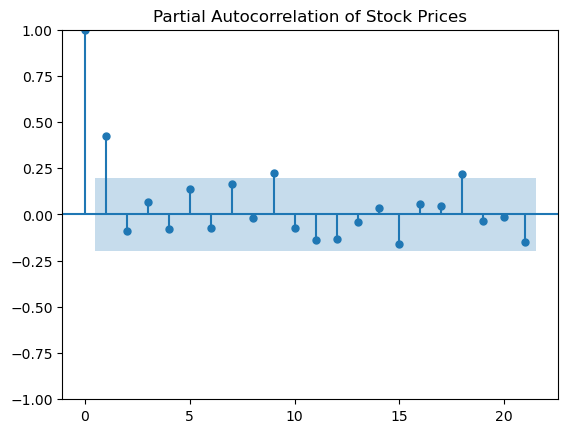

In [213]:
#Create a pacf plot of stock prices
pacf_value_stock_prices = plot_pacf(weekly_stock_prices_seasonally_removed,lags=21,title='Partial Autocorrelation of Stock Prices')

In [214]:
#P orders
P_orders_stock_prices = [1,5,7,9]

#### D Order for Stock Prices

In [215]:
#ADF test for stock prices
adf_test(weekly_stock_prices_seasonally_removed)

ADF Statistic:  -6.049144534378839
P-Value:  1.2901134480825736e-07
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [216]:
#As the ADF statistics is below the 99% threshold the graph is stationary
D_order_stock_prices = [0]

#### AR Model Selection

In [242]:
#### Select Best AR Model
select_best_ar_model(stock_prices['Daily Stock Prices'],p_orders_stock_prices)

{'best_aic': 297.5218128829326,
 'best_aic_model': 1,
 'best_bic': 305.33732344089685,
 'best_bic_model': 1}

#### Select Best MA Model

In [243]:
#Find the best MA 
select_best_ma_model(stock_prices['Daily Stock Prices'],q_orders_stock_prices)

{'best_aic': 296.11780425159344,
 'best_aic_model': 1,
 'best_bic': 303.9333148095577,
 'best_bic_model': 1}

#### Select Best ARMA Model

In [244]:
#Find best ARMA  model
select_best_arma_model(stock_prices['Daily Stock Prices'],p_orders_stock_prices,q_orders_stock_prices)

{'best_aic': 301.8619194448323,
 'best_aic_model': (17, 1),
 'best_bic': 323.6405285319348,
 'best_bic_model': (1, 1)}

#### Select Best ARIMA Model

In [248]:
#Find best ARIMA model
select_best_arima(stock_prices['Daily Stock Prices'],p_orders_electricity_consumption,q_orders_electricity_consumption,d_orders_stock_prices)

{'best_aic': 290.46747819013325,
 'best_aic_model': (11, 0, 7),
 'best_bic': 306.4650621308442,
 'best_bic_model': (1, 1, 1)}

#### Select Best SARIMA Model

In [252]:
#Find the best SARIMA model
select_best_sarima_model(stock_prices['Daily Stock Prices'],p_orders_stock_prices,d_orders_stock_prices,q_orders_stock_prices,P_orders_stock_prices,D_order_stock_prices,Q_orders_electricity_consumption,5)

{'aic': 292.80675940340893,
 'bic': 305.8326103333494,
 'pdq': (0, 0, 1),
 'seasonal_pdq': (3, 0, 0, 5)}

#### Best Model Selection
##### AR Model
AIC : 297.52, 
p : 1

BIC : 305.34,
p : 1
##### MA Model
AIC : 296.11,
q : 1

BIC : 303.93,
q : 1
##### ARMA Model
AIC : 301.86,
p : 17, 
q: 1

BIC : 323.64,
p : 1,
q : 1
##### ARIMA Model
AIC : 290.47,
p : 11, 
d : 0,
q : 7

BIC : 306.47
p : 1
d : 1
q : 1
##### SARIMA Model
AIC : 292.8

BIC : 305.83

p : 0
d : 0
q : 1
P : 3 


## Temperature Fluctuations
The temperature fluctuations data set includes a column that has normalised temperature data. Temperature fluctuations is going to be on a daily basis, assuming that these are the temperature records that were taken from the daily average on a given day.

### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [220]:
#Load in temperature fluctuations data
temperature_fluctuations = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Temperature Fluctuations')
temperature_fluctuations

,Unnamed: 0,Temperature Fluctuations
0,0,-0.369182
1,1,-0.608561
2,2,0.675689
3,3,1.542938
4,4,1.739233
...,...,...
95,95,1.006569
96,96,1.169455
97,97,1.216544
98,98,0.500300


In [221]:
#Preprocess temperature fluctuations
temperature_fluctuations['Incrementing Day'] = range(1, len(temperature_fluctuations)+1)
temperature_fluctuations['Day'] = pd.date_range('2024-01-01',periods=len(temperature_fluctuations))
temperature_fluctuations.drop(columns='Unnamed: 0',inplace=True)
temperature_fluctuations.set_index('Day',inplace=True)
temperature_fluctuations

,Temperature Fluctuations,Incrementing Day
Day,,
2024-01-01,-0.369182,1
2024-01-02,-0.608561,2
2024-01-03,0.675689,3
2024-01-04,1.542938,4
2024-01-05,1.739233,5
...,...,...
2024-04-05,1.006569,96
2024-04-06,1.169455,97
2024-04-07,1.216544,98


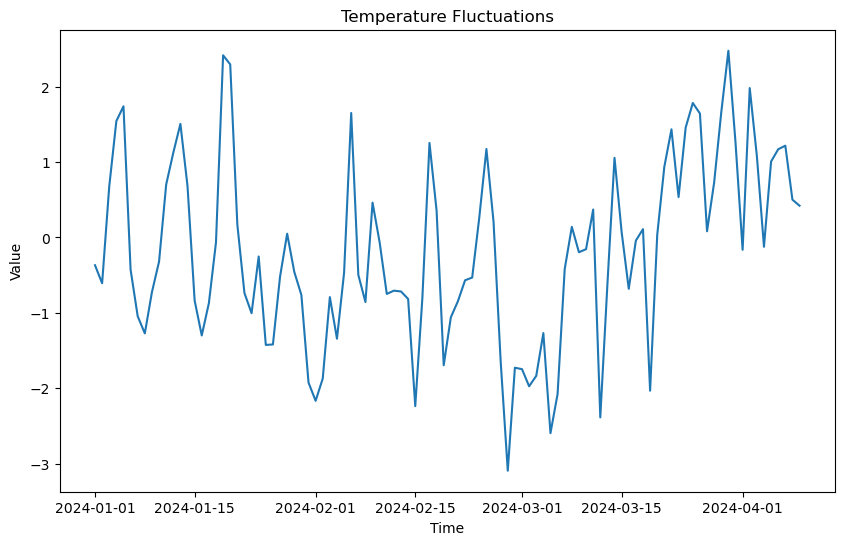

In [222]:
#Plot the time series
time_series(temperature_fluctuations.index,temperature_fluctuations['Temperature Fluctuations'],'Temperature Fluctuations','Time','Value')

#### Time Interval Decision

Temperature fluctuations are likely the daily temperatures over time. This is especially true as there is no clear overall pattern from looking at the graph, if it were weekly or monthly recordings you could expect to see a greater overall trend (likely upwards due to recent warmer temperatures across the globe)

In [223]:
#Daily temperature fluctuation data that has been decomposed
weekly_temperature_fluctuations_decomposition = decompose_seasonality(temperature_fluctuations['Temperature Fluctuations'],7)

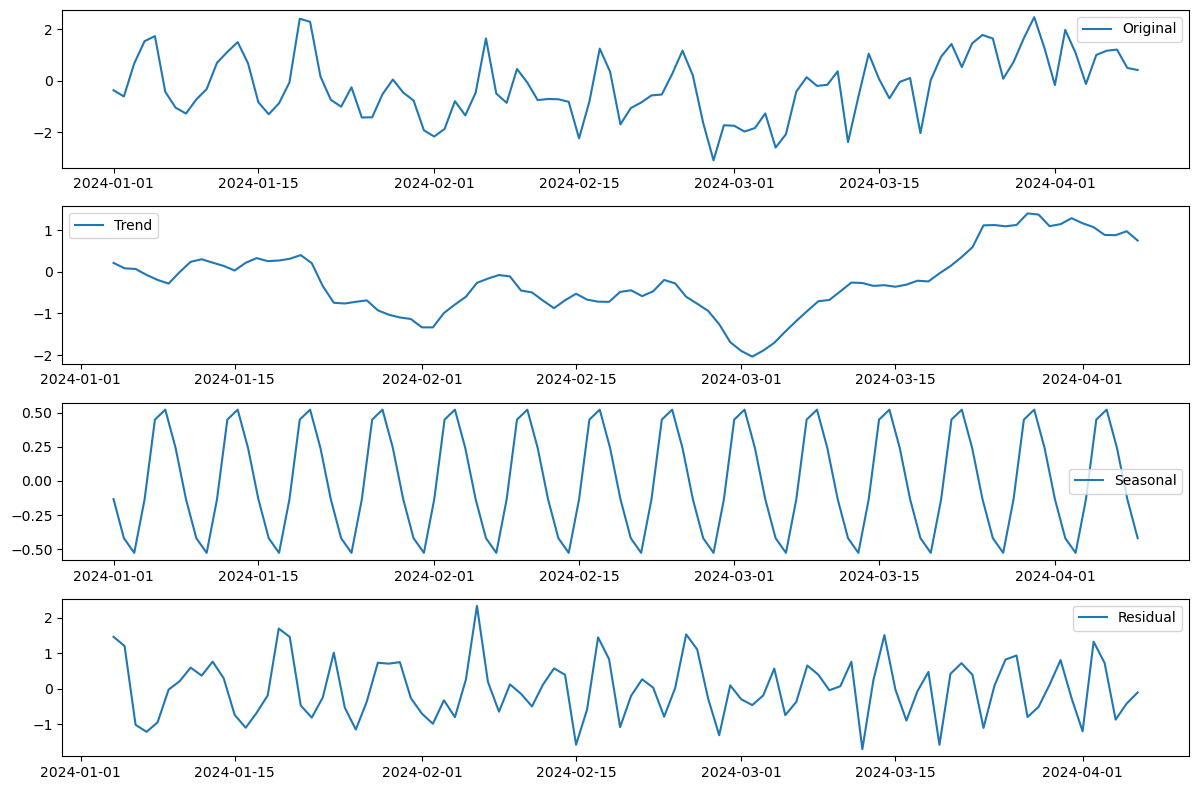

In [224]:
#Plot the temperature fluctuations seasonal decomposition
plot_seasonal_decomposition(temperature_fluctuations['Temperature Fluctuations'],7)

#### Weekly Seasonality Decomposition
Trend - The trend does not have any overall change in values

Cycles - There is a large dip in March of 2024 followed by an increase which remains constant as the data approaches April

Seasonal - There are days of the week which show higher values and lower values, these seasonal values are quite large

Residual - There is a residual value that is around the mean of 0

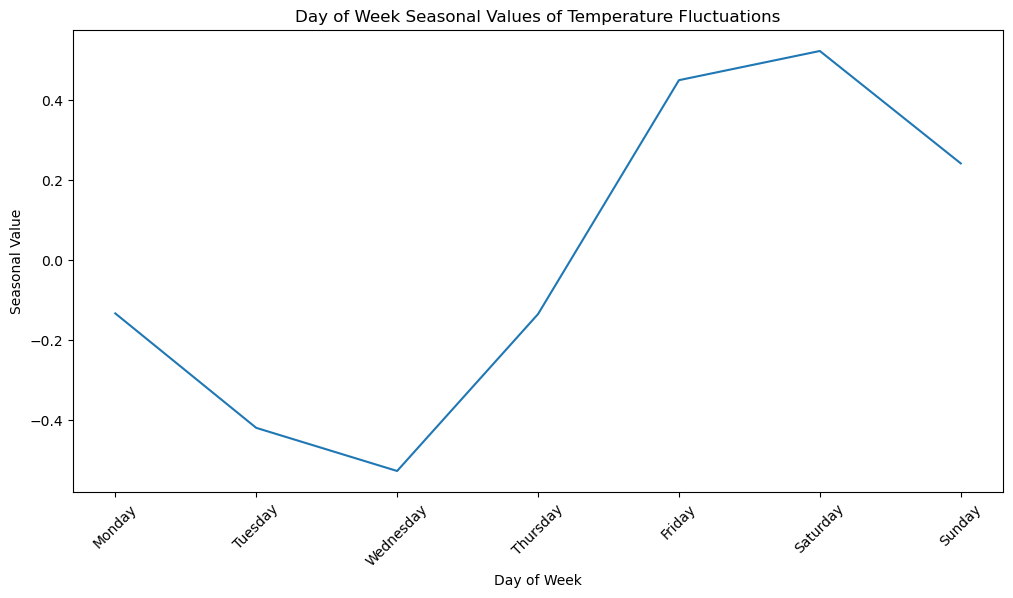

In [225]:
#Plot the seasonal values graph
seasonal_values_plot(weekly_temperature_fluctuations_decomposition[2],7,'seasonal','Day of Week Seasonal Values of Temperature Fluctuations',
                     'Day of Week',days_column,'Seasonal Value')

#### Weekly Seasonal Values
The lower seasonal values are from Monday through Thursday while the values increase on Friday, Saturday and Sunday. This seems to be a great place to live where the weekend values are higher.

#### Mean Absolute Error for Temperature Fluctuations

In [226]:
#MAE for Temperature Fluctuations
weekly_temperature_fluctuations_decomposition[3].dropna(inplace=True)
zeros_96 = np.zeros(len(weekly_temperature_fluctuations_decomposition[3]))
mean_absolute_error(zeros_96,weekly_temperature_fluctuations_decomposition[3])

0.6695272777983745

### Preliminary Analysis
- Descriptive Statistics: Compute and interpret the mean, median, variance, and standard deviation for each dataset.

In [227]:
#Create a new data frame that has weekly data
#This is going to make it easier to draw statistics from the data based on its seasonality
temperature_fluctuations_weekly=create_weekly_data(temperature_fluctuations,'Temperature Fluctuations','Incrementing Day')
temperature_fluctuations_weekly

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,-0.369182,-0.608561,0.675689,1.542938,1.739233,-0.427274,-1.046441
1,-1.273415,-0.725798,-0.321087,0.70056,1.122588,1.506231,0.67986
2,-0.837726,-1.301136,-0.872613,-0.065665,2.416052,2.295423,0.170638
3,-0.738635,-1.005904,-0.253269,-1.426691,-1.420482,-0.522103,0.049383
4,-0.456534,-0.764847,-1.925445,-2.168073,-1.873558,-0.79216,-1.344237
5,-0.469012,1.650578,-0.497454,-0.857461,0.461307,-0.068329,-0.750155
6,-0.706594,-0.717528,-0.816672,-2.238847,-0.805094,1.253238,0.353064
7,-1.696575,-1.060435,-0.845473,-0.568677,-0.53269,0.265529,1.173283
8,0.208419,-1.641953,-3.095597,-1.728888,-1.748114,-1.975303,-1.837374
9,-1.269411,-2.597269,-2.077996,-0.420718,0.140009,-0.196671,-0.156378


In [228]:
#Use the days replace function to fill in for week 14 as there is no general trend so the mean value would be appropriate to fill the NaN
missing_values_replace(days_replace,temperature_fluctuations_weekly,0,14)

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,-0.369182,-0.608561,0.675689,1.542938,1.739233,-0.427274,-1.046441
1,-1.273415,-0.725798,-0.321087,0.70056,1.122588,1.506231,0.67986
2,-0.837726,-1.301136,-0.872613,-0.065665,2.416052,2.295423,0.170638
3,-0.738635,-1.005904,-0.253269,-1.426691,-1.420482,-0.522103,0.049383
4,-0.456534,-0.764847,-1.925445,-2.168073,-1.873558,-0.79216,-1.344237
5,-0.469012,1.650578,-0.497454,-0.857461,0.461307,-0.068329,-0.750155
6,-0.706594,-0.717528,-0.816672,-2.238847,-0.805094,1.253238,0.353064
7,-1.696575,-1.060435,-0.845473,-0.568677,-0.53269,0.265529,1.173283
8,0.208419,-1.641953,-3.095597,-1.728888,-1.748114,-1.975303,-1.837374
9,-1.269411,-2.597269,-2.077996,-0.420718,0.140009,-0.196671,-0.156378


In [229]:
#Create the statistical table using the function that has been used previously
temperature_fluctuations_statistics = mean_median_variance_std_weekly(temperature_fluctuations_weekly,days_column)
temperature_fluctuations_statistics

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekly Mean,Weekly Median,Standard Deviation,Variance
0,-0.369182,-0.608561,0.675689,1.542938,1.739233,-0.427274,-1.046441,0.215200,-0.369182,1.104703,1.220368
1,-1.273415,-0.725798,-0.321087,0.70056,1.122588,1.506231,0.67986,0.241277,0.679860,1.026799,1.054315
2,-0.837726,-1.301136,-0.872613,-0.065665,2.416052,2.295423,0.170638,0.257854,-0.065665,1.518249,2.305080
3,-0.738635,-1.005904,-0.253269,-1.426691,-1.420482,-0.522103,0.049383,-0.759672,-0.738635,0.564226,0.318351
4,-0.456534,-0.764847,-1.925445,-2.168073,-1.873558,-0.79216,-1.344237,-1.332122,-1.344237,0.673815,0.454027
5,-0.469012,1.650578,-0.497454,-0.857461,0.461307,-0.068329,-0.750155,-0.075789,-0.469012,0.881956,0.777846
6,-0.706594,-0.717528,-0.816672,-2.238847,-0.805094,1.253238,0.353064,-0.525490,-0.717528,1.088115,1.183994
7,-1.696575,-1.060435,-0.845473,-0.568677,-0.53269,0.265529,1.173283,-0.466434,-0.568677,0.935329,0.874840
8,0.208419,-1.641953,-3.095597,-1.728888,-1.748114,-1.975303,-1.837374,-1.688401,-1.748114,0.973824,0.948332
9,-1.269411,-2.597269,-2.077996,-0.420718,0.140009,-0.196671,-0.156378,-0.939776,-0.420718,1.060877,1.125460


The dataframe includes the 14 weeks of data that take place in measuring temperature fluctuations. Once again the statistical data that is applicable to this problem is the weekly mean, median standard deviation and variance columns.

#### Weekly Mean for Temperature Fluctuations

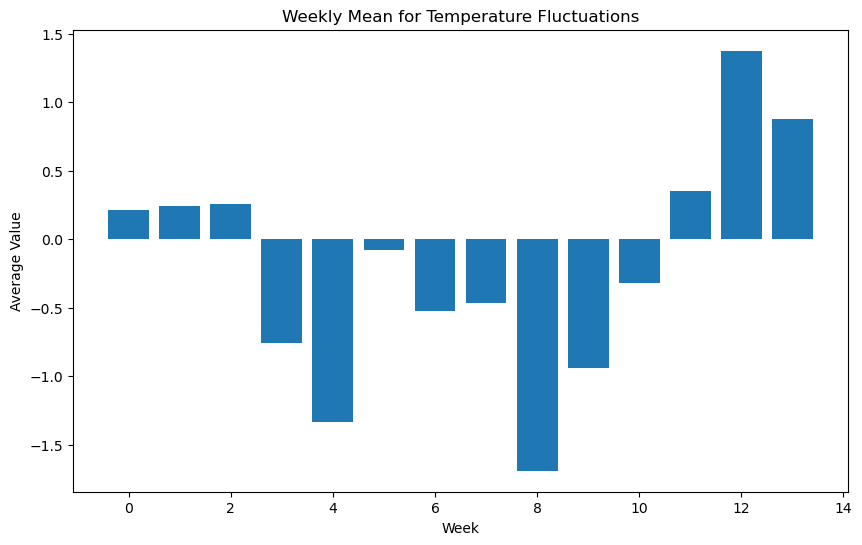

In [246]:
#Bar chart of weekly average temperature fluctuations
bar_chart(temperature_fluctuations_statistics.index[0:14],temperature_fluctuations_statistics['Weekly Mean'][0:14],'Weekly Mean for Temperature Fluctuations','Week','Average Value')

You can see the sinusodial pattern that is followed by looking at the mean value. This is from the high that takes place around week 12 with high values up until week 3. This is coupled with a period of lower values from week 4-11 which is the downturn of the sinusoidal pattern.

#### Weekly Median for Temperature Fluctuations

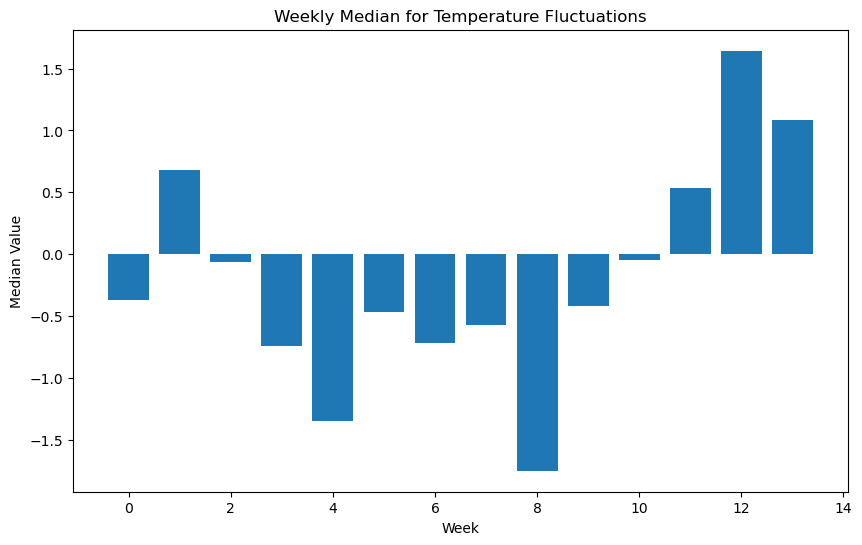

In [245]:
#Create a weekly median of temperature fluctuations graph
bar_chart(temperature_fluctuations_statistics.index[0:14],temperature_fluctuations_statistics['Weekly Median'][0:14],'Weekly Median for Temperature Fluctuations','Week','Median Value')

The median value follows an extremely similar pattern after week 3 but before that it is quite different. This might be reflected in the variance.

#### Weekly Variance for Temperature Fluctuations

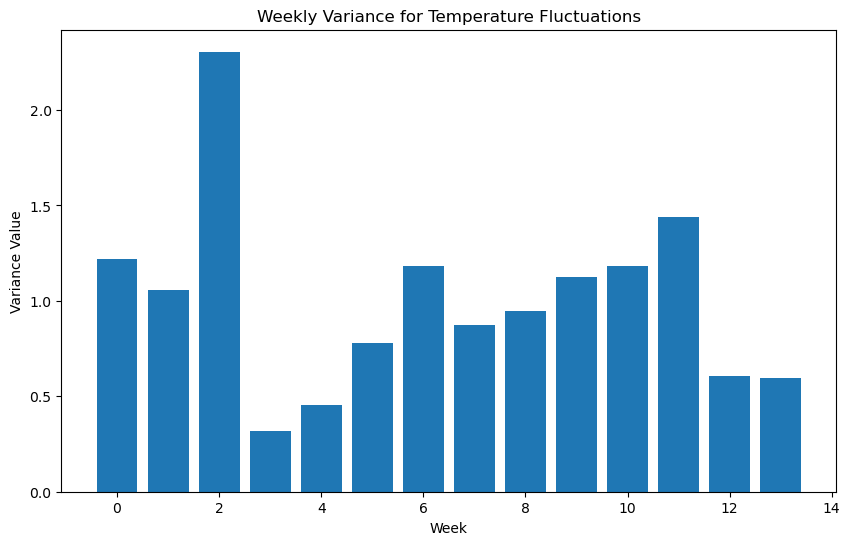

In [249]:
#Create a weekly variance of temperature fluctuations graph
bar_chart(temperature_fluctuations_statistics.index[0:14],temperature_fluctuations_statistics['Variance'][0:14],'Weekly Variance for Temperature Fluctuations','Week','Variance Value')

As predicted this does make a difference in the variance as weeks 1-3 have a much higher variance compared to the other values, especially week 3.

#### Weekly Standard Deviation for Temperature Fluctuations

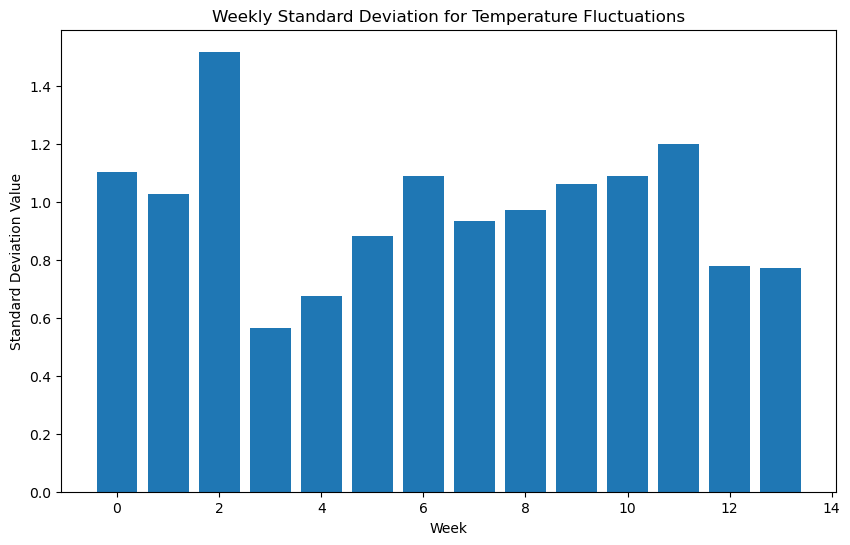

In [250]:
#Create a weekly standard deviation of temperature fluctuations graph
bar_chart(temperature_fluctuations_statistics.index[0:14],temperature_fluctuations_statistics['Standard Deviation'][0:14],'Weekly Standard Deviation for Temperature Fluctuations','Week','Standard Deviation Value')

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### MA Order for Temperature Fluctuations

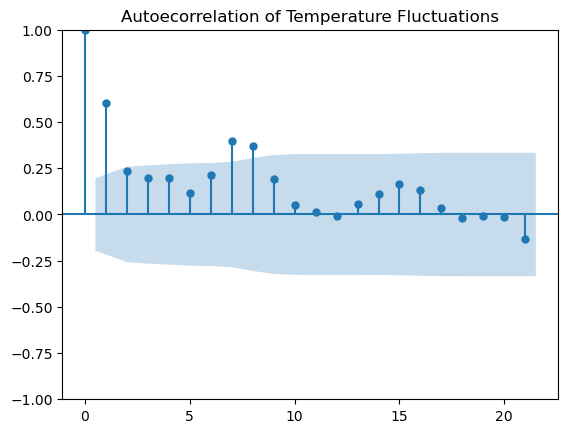

In [234]:
#Plot the ACF values
acf_values = plot_acf(temperature_fluctuations['Temperature Fluctuations'],lags=21,title='Autoecorrelation of Temperature Fluctuations')

In [235]:
#List potential ma (q) orders
ma_orders_temperature_fluctuations = [1,7,8]

#### AR Order for Temperature Fluctuation

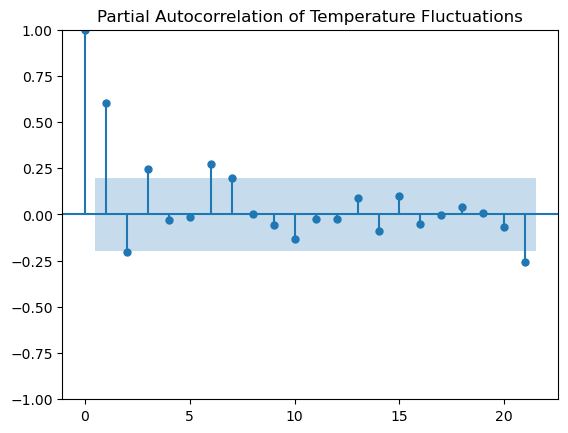

In [255]:
#Plot the PACF Values
pacf_values = plot_pacf(temperature_fluctuations['Temperature Fluctuations'],lags=21,title='Partial Autocorrelation of Temperature Fluctuations')

In [237]:
#List potential ar (p) orders
ar_orders_temperature_fluctuations = [1,2,3,6,7]

#### d Order for Temperature Fluctuation

In [238]:
#Check the stationarity of temperature fluctuations
adf_test(temperature_fluctuations['Temperature Fluctuations'])

ADF Statistic:  -1.5400991438956082
P-Value:  0.5135899098620552
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


As this is not stationary, take the first difference then recheck

In [239]:
#Create a new column that takes the first difference of temperature fluctuations
temperature_fluctuations['First Difference'] = temperature_fluctuations['Temperature Fluctuations'].diff()
temperature_fluctuations = temperature_fluctuations[1::]
adf_test(temperature_fluctuations['First Difference'])

ADF Statistic:  -7.86588692238614
P-Value:  5.136316200920877e-12
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


As this is now below the threshold, it is considered stationary which can now be used in the ARIMA model.

In [240]:
#List the potential i (d) orders
i_orders_temperature_fluctuations = [0,1,2]

#### Removing Seasonality from Data for P,D,Q

We are trying to find the values for the SARIMA model. In order to do this, we have to remove the seasonality from the original data. This creates seasonally adjusted data which is used for the SARIMA model. 

In [256]:
weekly_temperature_fluctuations_seasonal_removed = weekly_temperature_fluctuations_decomposition[0] - weekly_temperature_fluctuations_decomposition[2]
weekly_temperature_fluctuations_seasonal_removed

Day
2024-01-01   -0.236081
2024-01-02   -0.189652
2024-01-03    1.202355
2024-01-04    1.677718
2024-01-05    1.289765
                ...   
2024-04-05    0.557102
2024-04-06    0.647079
2024-04-07    0.974932
2024-04-08    0.633401
2024-04-09    0.839390
Length: 100, dtype: float64

#### Q order for Temperature Fluctuations

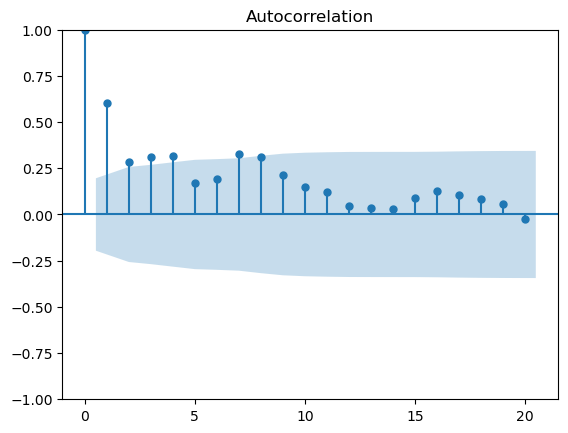

In [258]:
#Plot the new acf
acf_values_temperature_fluctuations_seasonally_adjusted = plot_acf(weekly_temperature_fluctuations_seasonal_removed)

In [ ]:
#Orders for Q
Q_orders_temperature_fluctuations = [1,2,3,4,7,8]

#### P order for Temperature Fluctuations

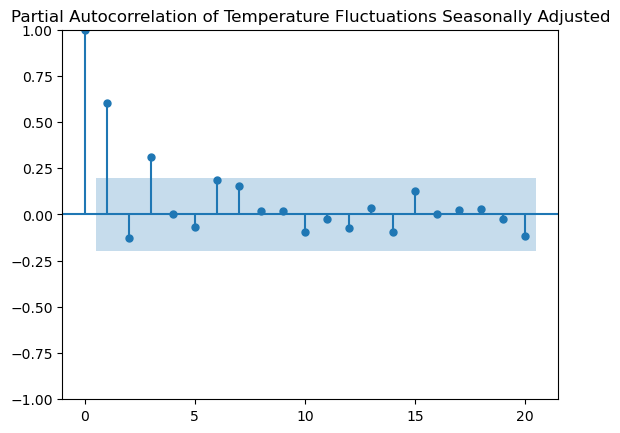

In [260]:
#Plot the PACF values
pacf_values_temperature_fluctuations_seasonally_adjusted = plot_pacf(weekly_temperature_fluctuations_seasonal_removed, lags = 20, title = 'Partial Autocorrelation of Temperature Fluctuations Seasonally Adjusted')

In [ ]:
#Orders for P
P_orders_temperature_fluctuations = [1,3,6]

#### D order for Temperature Fluctuations

In [261]:
adf_test(weekly_temperature_fluctuations_seasonal_removed)

ADF Statistic:  -3.0580656215215885
P-Value:  0.029816220695146455
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [263]:
D_order_temperature_fluctuations = [0,1]

#### Parameters for Box Jenkins Models
- q: 1,7,8
- p: 1,2,3,6,7
- d: 0,1,2
- Q: 1,2,3,4,7,8
- P: 1,3,6
- D: 0,1
- s: 7 

#### AR Model Selection

In [ ]:
# Fi

#### AIC Model Selection
- AR : 7
- I : 0 
- MA : 8

AIC Value - 270.18

#### BIC Model Selection
- AR : 1
- I : 0
- MA : 1

BIC Value - 287.03

## Advertising Impact
The adveritisng impact dataset includes a column called Advertising Impact. This is likely going to look at a performance metric of sales and seeing how much a marketing technique helped with that performance mectric

### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [ ]:
#load in the advertising imapct data
advertising_impact = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Advertising Impact')
advertising_impact

In [ ]:
#Preprocess the data
advertising_impact.drop(columns='Unnamed: 0',inplace=True)
advertising_impact['Incrementing Day'] = range(1, len(advertising_impact)+1)
advertising_impact['Day'] = pd.date_range('2024-01-01',periods=len(advertising_impact))
advertising_impact.set_index('Day',inplace=True)
advertising_impact

In [ ]:
#Plot the time series
time_series(advertising_impact.index,advertising_impact['Advertising Impact'],'Advertising Impact','Time','Values')

#### Time Interval Decision
The impact of advertising is likely to be recorded on a daily basis. At large corporations there is daily spending of advertising and measuring its impact on a daily basis makes logical sense.

In [ ]:
#Decompose the data into its individual parts, these can be accessed by indexing through the results
weekly_advertising_impact_decomposition = decompose_seasonality(advertising_impact['Advertising Impact'],7)

In [ ]:
#Plot the seasonal decomposition of advertising impact
plot_seasonal_decomposition(advertising_impact['Advertising Impact'],7)

#### Weekly Seasonality Decomposition

Trend - There is a very clear trend that seems to be almost completely linear once the seasonal movement has been taken out

Cycles - There are no cycles

Seasonality - There are spikes and troughs that are displayed in the seasonality

Residual - The residual value seems to have periods where there is prolonged peaks

#### Trend Decomposition of Advertising Impact

In [ ]:
#Plot the trend with line of best fit
weekly_advertising_impact_decomposition[1].dropna(inplace=True)
plot_least_squares_line(advertising_impact['Incrementing Day'][0:94],weekly_advertising_impact_decomposition[1],
                        'Advertising Impact with Least Squares Line','Day','Advertising Impact')

The line of best fit very accurately follows the original data. This confirms that there is a trend that is present in the graph.

#### Seasonality Decomposition of Advertising Impact

In [ ]:
#Graph the seasonal values
seasonal_values_plot(weekly_advertising_impact_decomposition[2],7,'seasonal','Daily Seasonal Values of Advertising Impacts',
                     'Days of Week',days_column,'Seasonal Value')

Advertising impacts are lowest on Thursdays while they peak around Sunday and Monday, the movement is pretty linear. The middle of the week might be a time where people are not on their phones as much which might reduced the impact of using social media marketing.

In [ ]:
#MAE for Advertising Impact
weekly_advertising_impact_decomposition[3].dropna(inplace=True)
mean_absolute_error(zeros_96,weekly_advertising_impact_decomposition[3])

Observe that the mae is much higher than other values, this might be revelaed in the acf and pacf plots for why this is the case.

### Preliminary Analysis

In [ ]:
#Create a new data frame that converts daily recordings to weekly
#This is goign to improve ease of drawing insightful statistics based on weeks and day of week
advertising_impact_statistics = create_weekly_data(advertising_impact,'Advertising Impact', 'Incrementing Day')
advertising_impact_statistics

#### Dealing with Missing Values
As there is a clear linear trend, the missing values are going to replaced with the most recent values in week 14. This is going to reduce the impact of not moving with the trend as week incremental continues.

In [ ]:
#Replace the NaN values with the values from before
for day in days_replace:
    advertising_impact_statistics[day][14:15] = advertising_impact_statistics[day][13:14]
    advertising_impact_statistics

In [ ]:
#Create the statistical table that includes the components apart of the preliminary analysis
advertising_impact_statistics = mean_median_variance_std_weekly(advertising_impact_statistics,days_column)
advertising_impact_statistics

#### Weekly Mean of Advertising Impact

In [ ]:
#Create a bar chart of the mean of the values from weeks 1-15
bar_chart(advertising_impact_statistics.index[0:15],advertising_impact_statistics['Weekly Mean'][0:15],
          'Weekly Mean of Advertising Impact','Week','Mean Value')

This has a clear negatively skewed spread which represents the negative trend to the data. This is very clear and clearly as time has continued the impacts of advertising has increasingly gotten worst

#### Weekly Median of Advertising Impact

In [ ]:
#Create a bar chart of the median of advertising impact
bar_chart(advertising_impact_statistics.index[0:15],advertising_impact_statistics['Weekly Median'][0:15],
          'Weekly Median of Advertising Impact','Week','Median Value')

The median value follows an extremely similar progression as mean does.

#### Weekly Variance of Advertising Impact

In [ ]:
#Create a bar chart of the variance
bar_chart(advertising_impact_statistics.index[0:14],advertising_impact_statistics['Variance'][0:14],
          'Weekly Variance of Advertising Impact','Week','Variance')

The variance is quite low which makes sense considering the similar pattern that the mean and median follows. THis is the variance with denormalised values which is why they are not as small as before.

#### Weekly Standard Deviation of Advertising Impact

In [ ]:
#Create a bar chart of standard deviation
bar_chart(advertising_impact_statistics.index[0:14],advertising_impact_statistics['Standard Deviation'][0:14],
          'Weekly Standard Deviation of Advertising Impact','Week','Standard Deviation')

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### MA Order for Advertising Impact

In [ ]:
#Plot the ACF values 
acf_values = plot_acf(advertising_impact['Advertising Impact'],lags=21,title='Autocorrelation of Advertising Impact')

Observe the immediate difference that is noticed to the previous graph. The autocorrelaiton is very high and remains strong even as time continues. This is because of the strong linear trend that is displayed. This is again why the ACF plot looks for the MA component.

In [ ]:
#List potential ma (q) orders
#One is the only appropriate value as the rest are getting smaller
ma_orders_advertising_impact = [1]

#### AR Order for Advertising Impact

In [ ]:
#Plot the pacf value
pacf_values = plot_pacf(advertising_impact['Advertising Impact'],lags=21,title='Partial Autocorrealtion of Advertising Impact')

In [ ]:
#List potential ar (p) orders
ar_orders_adveritising_impact = [1,2,3]

#### I Order for Advertising Impact

In [ ]:
#Check the stationarity of advertising impacts
adf_test(advertising_impact['Advertising Impact'])

The ADF statistic is no way near the value that is required to be at the threshold. Let's take the first difference

In [ ]:
#First difference of advertising imapct
advertising_impact['First Difference'] = advertising_impact['Advertising Impact'].diff()
advertising_impact = advertising_impact[1::]
adf_test(advertising_impact['First Difference'])

It is now at the threshold to be considered stationary

In [ ]:
#List potential I (d) orders 
i_orders_advertising_impact = [0,1]

In [ ]:
#Select the best model based on criteria AIC and BIC
select_best_time_series_model(advertising_impact['Advertising Impact'],ar_orders_adveritising_impact,ma_orders_advertising_impact,i_orders_advertising_impact)

#### AIC Model Selection
- AR : 2
- I : 1
- MA : 1

AIC Value - 270.30

#### BIC Model Selection
- AR : 1
- I : 1
- MA : 1

BIC Value - 279.07

## Sales Data
Sales data explicity states that the sales are monthly with an index of 120 it can be assumed that the data is taken from 10 years. 

### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [ ]:
#Load in the sales data
sales_data = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Sales Data')
sales_data

#### Time Interval Decision
Given in the name of the the dataframe, this is sales data from the past 10 years (12 months in each year). 

In [ ]:
#Preprocess data
sales_data['Incrementing Month'] = range(1, len(sales_data)+1)
sales_data.drop(columns='Unnamed: 0',inplace=True)
sales_data['Day'] = pd.date_range('2014-01-01',periods=len(sales_data),freq='M')
sales_data.set_index('Day',inplace=True)
sales_data

In [ ]:
#Plot the time series
time_series(sales_data.index,sales_data['Monthly Sales'],'Monthly Sales','Time','Values')

In [ ]:
#Seasonally decompose the sales data into its own parts as variables
monthly_sales_data_decomposition = decompose_seasonality(sales_data['Monthly Sales'],12)

In [ ]:
#Plot the above variables as individual graphs
plot_seasonal_decomposition(sales_data['Monthly Sales'],12)

Trend - There is an overall decrease in the average value of data

Cycles - There is a cycle of higher values from 2015 to 2019 before a slump in 2020 to 2021 and another decline through 2022

Seasonal - There are months which seem to be performing better than others

Residual - The residual values are quite high but do hover around a mean of between 0 and 1

In [ ]:
#Plot the trend with line of best fit
monthly_sales_data_decomposition[1].dropna(inplace=True)
plot_least_squares_line(sales_data['Incrementing Month'][0:108],monthly_sales_data_decomposition[1],
                        'Monthly Sales with Least Squares Line','Month','Normalised Monthly Sales')

There is an overall decrease in the number of sales over this time period. 

#### Seasonality Decomposition of Sales Data

In [ ]:
#Plot the seasonal values
seasonal_values_plot(monthly_sales_data_decomposition[2],12,'seasonal','Monthly Seasonal Values of Sales Data',
                     'Months of Year',months_list,'Seasonal Value')

Seasonal values show that February and March are the lowest while sales peak in October. This is likely the result of sales for a product that is most popular in the fall. This could be the sale of outdoor furniture. 

In [ ]:
#MAE for Sales Data
monthly_sales_data_decomposition[3].dropna(inplace=True)
zeros_108 = np.zeros(len(monthly_sales_data_decomposition[3]))
mean_absolute_error(zeros_108,monthly_sales_data_decomposition[3])

This is the worst average absolute error that has been observed.

In [ ]:
#Create a new data frame that converts daily recordings to weekly
#This is goign to improve ease of drawing insightful statistics based on weeks and day of week
monthly_sales_data_statistics = create_monthly_data(sales_data,'Monthly Sales', 'Incrementing Month')
monthly_sales_data_statistics

In [ ]:
#Create statistical table using the function above
mean_median_variance_std_monthly(monthly_sales_data_statistics,months_list)

The dataframe is similar to the weekly mean, median, variance and standard deviation table creation that took place before. However, now it is based on the month of the year for the year value. This is going to be useful for looking at how the year values change over time.

#### Yearly Mean for Sales Data

In [ ]:
#Create a bar chart of the mean of the values from years 1-10
bar_chart(monthly_sales_data_statistics.index[0:10],monthly_sales_data_statistics['Monthly Mean'][0:10],
          'Yearly Mean for Sales Data','Year','Mean Value')

#### Yearly Median for Sales Data

In [ ]:
#Create a bar chart of the median values of sales data
bar_chart(monthly_sales_data_statistics.index[0:10],monthly_sales_data_statistics['Monthly Median'][0:10],
          'Yearly Median','Year', 'Median Value')

#### Yearly Variance for Sales Data

In [ ]:
#Create a bar chart for for variance of sales data
bar_chart(monthly_sales_data_statistics.index[0:10],monthly_sales_data_statistics['Variance'][0:10],
          'Variance','Year', 'Variance Value')

#### Yearly Standard Deviation for Sales Data

In [ ]:
#Bar chart for standard deviaiton of sales data
bar_chart(monthly_sales_data_statistics.index[0:10],monthly_sales_data_statistics['Standard Deviation'][0:10],
          'Standard Deviation','Year', 'Standard Deviation')

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### MA Order for Sales Data

In [ ]:
#Plot the ACF values
acf_values = plot_acf(sales_data['Monthly Sales'],lags=20,title='Autocorrelation for Monthly Sales')

#### AR Order for Sales Data

In [ ]:
pacf_values = plot_pacf(sales_data['Monthly Sales'],lags=20,title='Partial Autocorrelation for Monthly Sales')

#### I Order for Sales Data

In [ ]:
adf_test(sales_data['Monthly Sales'])

#### ARIMA Model Selection

In [ ]:
#Load in the exchange rates
exchange_rate = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Exchange Rates')
exchange_rate

In [ ]:
#Create a list of series to plot
list_series = [(exchange_rate.index,exchange_rate['Exchange Rates']),(exchange_rate.index,exchange_rate['Economic Indicators']]

#Plot the time series
multiple_time_series(list_series,'Exchange Rate Data','Time','Value')